In [1]:
from dask.distributed import Client

In [2]:
client = Client(threads_per_worker=1)

In [3]:
client

<Client: 'tcp://127.0.0.1:41537' processes=12 threads=12, memory=46.00 GiB>

In [4]:
import xarray as xr
import matplotlib.pyplot as plt

In [5]:
cd /g/data/tm70/as2285/om3-scripts/expts_manager/no_ocean_cpl

/g/data/tm70/as2285/om3-scripts/expts_manager/no_ocean_cpl


In [6]:
ls

archive@                       dev-025_crid.o130009525  manifests/
build_intake_ds.sh.e130002866  diag_table               metadata.yaml
build_intake_ds.sh.e130012971  docs/                    MOM_input
build_intake_ds.sh.o130002866  drof_in                  MOM_override
build_intake_ds.sh.o130012971  drof.streams.xml         nuopc.runconfig
config.yaml                    drv_in                   nuopc.runseq
datm_in                        fd.yaml                  README.md
datm.streams.xml               ice_in
dev-025_crid.e130009525        input.nml


In [7]:
! grep advection ice_in

  advection = "remap"


In [8]:
! grep DT MOM_input

DT = 1350.0                     !   [s]
                                ! be an integer fraction of the forcing time-step (DT_FORCING in ocean-only mode
DT_THERM = 1350.0               !   [s] default = 1800.0
                                ! The thermodynamic and tracer advection time step. Ideally DT_THERM should be
                                ! an integer multiple of DT and less than the forcing or coupling time-step,
                                ! unless THERMO_SPANS_COUPLING is true, in which case DT_THERM can be an integer
                                ! multiple of the coupling timestep.  By default DT_THERM is set to DT.
DTBT_RESET_PERIOD = 0.0         !   [s] default = 3600.0
                                ! The period between recalculations of DTBT (if DTBT <= 0). If DTBT_RESET_PERIOD
                                ! is negative, DTBT is set based only on information available at
                                ! initialization.  If 0, DTBT will be set every dynam

In [9]:
! cat nuopc.runseq

runSeq:: 
@1350 
  MED med_phases_aofluxes_run
  MED med_phases_prep_ocn_accum
  MED med_phases_ocnalb_run
  MED med_phases_diag_ocn
  MED med_phases_prep_ice
  MED -> ICE :remapMethod=redist
  MED med_phases_prep_ocn_avg
  ICE
  ROF
  OCN
  OCN -> MED :remapMethod=redist
  MED med_phases_post_ocn
  MED med_phases_diag_rof
  MED med_phases_diag_ice_ice2med
  ICE -> MED :remapMethod=redist
  MED med_phases_post_ice
  ATM
  ATM -> MED :remapMethod=redist
  MED med_phases_post_atm
  MED med_phases_diag_atm
  MED med_phases_diag_ice_med2ice
  ROF -> MED :remapMethod=redist
  MED med_phases_post_rof
  MED med_phases_diag_accum
  MED med_phases_diag_print
  MED med_phases_history_write        
  MED med_phases_restart_write        
  MED med_phases_profile              
@ 
::


In [10]:
cice_files = ! ls archive/output*/access-om3.cice.*.nc

In [11]:
cice_files

['archive/output000/access-om3.cice.1901-03-26.nc',
 'archive/output000/access-om3.cice.1901-03-27.nc',
 'archive/output000/access-om3.cice.1901-03-28.nc',
 'archive/output000/access-om3.cice.1901-03-29.nc',
 'archive/output000/access-om3.cice.1901-03-30.nc']

In [12]:
cice_ds = xr.open_mfdataset(cice_files)

In [13]:
cice_ds

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 5, nbnd: 2, nc: 5, nkice: 4, nksnow: 1, nkbio: 3,
                  nkaer: 5, nj: 1080, ni: 1440)
Coordinates:
  * time         (time) object 40B 1901-03-26 12:00:00 ... 1901-03-30 12:00:00
Dimensions without coordinates: nbnd, nc, nkice, nksnow, nkbio, nkaer, nj, ni
Data variables: (12/53)
    time_bounds  (time, nbnd) object 80B dask.array<chunksize=(1, 2), meta=np.ndarray>
    NCAT         (time, nc) float64 200B dask.array<chunksize=(1, 5), meta=np.ndarray>
    VGRDi        (time, nkice) float64 160B dask.array<chunksize=(1, 4), meta=np.ndarray>
    VGRDs        (time, nksnow) float64 40B dask.array<chunksize=(1, 1), meta=np.ndarray>
    VGRDb        (time, nkbio) float64 120B dask.array<chunksize=(1, 3), meta=np.ndarray>
    VGRDa        (time, nkaer) float64 200B dask.array<chunksize=(1, 5), meta=np.ndarray>
    ...           ...
    dvidtt       (time, nj, ni) float64 62MB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    dvidtd       (time, nj, ni) float64 62MB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    hisnap       (time, nj, ni) float64 62MB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    aisnap       (time, nj, ni) float64 62MB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    sifb         (time, nj, ni) float64 62MB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    dvirdgdt     (time, nj, ni) float64 62MB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
Attributes:
    title:               access-om3
    contents:            Diagnostic and Prognostic Variables
    source:              CICE Sea Ice Model, unknown_version_name
    comment:             All years have exactly 365 days
    comment2:            File written on model date 19010327
    comment3:            seconds elapsed into model date:      0
    time_period_freq:    day_1
    time_axis_position:  middle
    conventions:         CF-1.0
    history:             This dataset was created on 2024-12-03 at 16:47
    io_flavor:           io_pio2 hdf5

In [14]:
crash_point = cice_ds.isel(ni=1068,nj=1001)

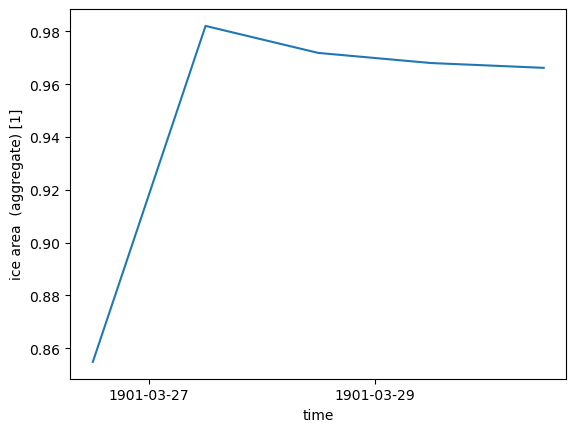

In [15]:
crash_point.aice.plot()

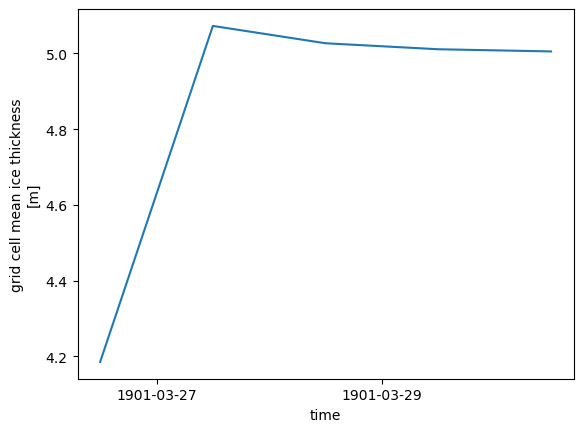

In [16]:
crash_point.hi.plot()

In [17]:
grid_ds = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')

In [18]:
grid_ds

<xarray.Dataset> Size: 93MB
Dimensions:     (xt_ocean: 1440, yt_ocean: 1080, time: 1, xu_ocean: 1440,
                 yu_ocean: 1080)
Coordinates:
  * xt_ocean    (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean    (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.84 89.95
  * time        (time) object 8B 0002-01-01 00:00:00
  * xu_ocean    (xu_ocean) float64 12kB -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yu_ocean    (yu_ocean) float64 9kB -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
    geolon_t    (yt_ocean, xt_ocean) float32 6MB ...
    geolat_t    (yt_ocean, xt_ocean) float32 6MB ...
    geolon_c    (yu_ocean, xu_ocean) float32 6MB ...
    geolat_c    (yu_ocean, xu_ocean) float32 6MB ...
Data variables:
    ht          (yt_ocean, xt_ocean) float32 6MB ...
    hu          (yu_ocean, xu_ocean) float32 6MB ...
    dxt         (yt_ocean, xt_ocean) float32 6MB ...
    dyt         (yt_ocean, xt_ocean) float32 6MB ...
    dxu         (yu_ocean, xu_ocean) float32 6MB ...
    dyu         (yu_ocean, xu_ocean) float32 6MB ...
    area_t      (yt_ocean, xt_ocean) float32 6MB ...
    area_u      (yu_ocean, xu_ocean) float32 6MB ...
    kmt         (yt_ocean, xt_ocean) float32 6MB ...
    kmu         (yu_ocean, xu_ocean) float32 6MB ...
    drag_coeff  (time, yu_ocean, xu_ocean) float32 6MB ...
Attributes:
    filename:   ocean_grid.nc
    title:      MOM5
    grid_type:  mosaic
    grid_tile:  1

In [19]:
grid_ds=grid_ds.rename({'xt_ocean':'ni', 'yt_ocean':'nj'})

In [20]:
cice_ds['TLON']=grid_ds['geolon_t']

In [21]:
cice_ds['TLAT']=grid_ds['geolat_t']

In [22]:
cice_ds

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 5, nbnd: 2, nc: 5, nkice: 4, nksnow: 1, nkbio: 3,
                  nkaer: 5, nj: 1080, ni: 1440)
Coordinates:
  * time         (time) object 40B 1901-03-26 12:00:00 ... 1901-03-30 12:00:00
  * ni           (ni) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * nj           (nj) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolon_t     (nj, ni) float32 6MB ...
    geolat_t     (nj, ni) float32 6MB ...
Dimensions without coordinates: nbnd, nc, nkice, nksnow, nkbio, nkaer
Data variables: (12/55)
    time_bounds  (time, nbnd) object 80B dask.array<chunksize=(1, 2), meta=np.ndarray>
    NCAT         (time, nc) float64 200B dask.array<chunksize=(1, 5), meta=np.ndarray>
    VGRDi        (time, nkice) float64 160B dask.array<chunksize=(1, 4), meta=np.ndarray>
    VGRDs        (time, nksnow) float64 40B dask.array<chunksize=(1, 1), meta=np.ndarray>
    VGRDb        (time, nkbio) float64 120B dask.array<chunksize=(1, 3), meta=np.ndarray>
    VGRDa        (time, nkaer) float64 200B dask.array<chunksize=(1, 5), meta=np.ndarray>
    ...           ...
    hisnap       (time, nj, ni) float64 62MB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    aisnap       (time, nj, ni) float64 62MB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    sifb         (time, nj, ni) float64 62MB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    dvirdgdt     (time, nj, ni) float64 62MB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    TLON         (nj, ni) float32 6MB ...
    TLAT         (nj, ni) float32 6MB ...
Attributes:
    title:               access-om3
    contents:            Diagnostic and Prognostic Variables
    source:              CICE Sea Ice Model, unknown_version_name
    comment:             All years have exactly 365 days
    comment2:            File written on model date 19010327
    comment3:            seconds elapsed into model date:      0
    time_period_freq:    day_1
    time_axis_position:  middle
    conventions:         CF-1.0
    history:             This dataset was created on 2024-12-03 at 16:47
    io_flavor:           io_pio2 hdf5

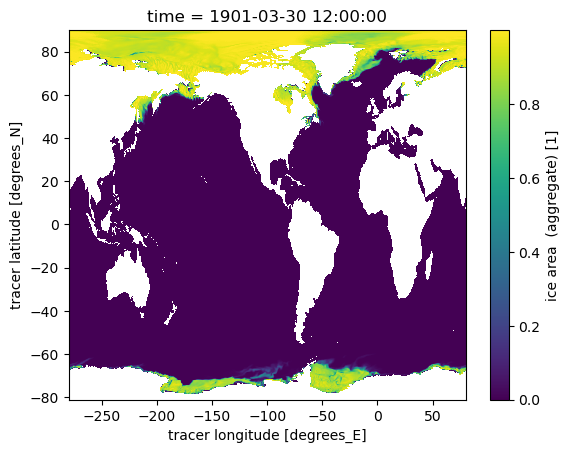

In [23]:
ax = plt.subplot()

cice_ds.aice.isel(time=-1).plot(ax=ax, x = 'geolon_t' , y = 'geolat_t' )

ax.add_patch(plt.Rectangle((1064,996),width=10, height=10, color='red', fill=None))

plt.show()

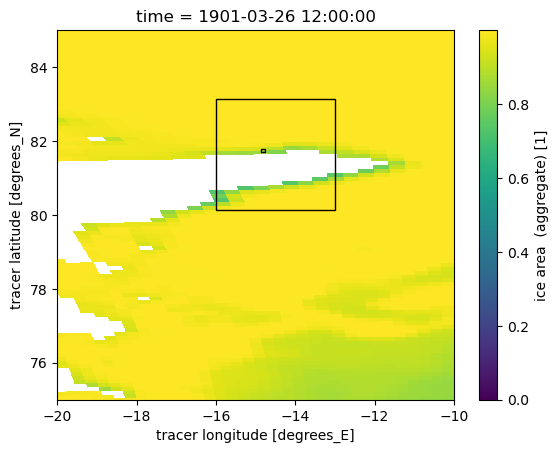

In [24]:
plt.figure()
ax = plt.subplot()

cice_ds.aice.isel(time=0).plot(ax=ax, x = 'geolon_t' , y = 'geolat_t')
plt.ylim([75,85])
plt.xlim([-20,-10])

ax.add_patch(plt.Rectangle((-16,80.125),width=3, height=3, color='black', fill=None))
ax.add_patch(plt.Rectangle((-14.8643879243489,81.6865092532964),width=0.1, height=0.1, color='black', fill=None))


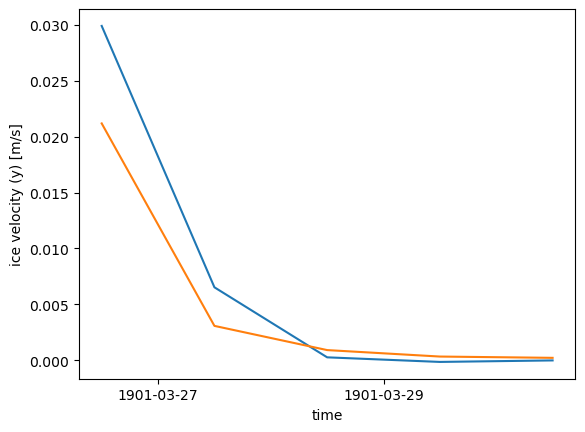

In [25]:
for v in ['uvel','vvel']:
    crash_point[v].plot()

(-20.0, -10.0)

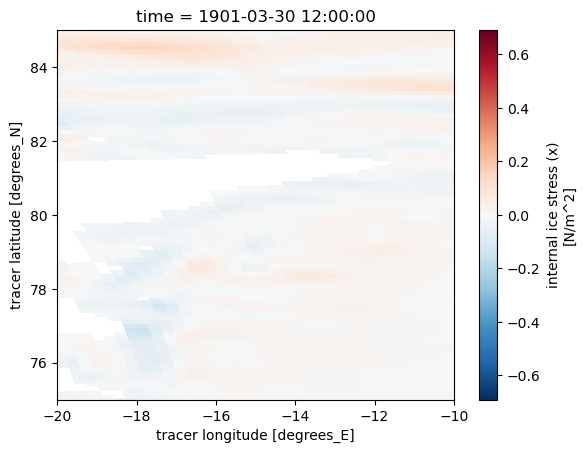

In [26]:
cice_ds.isel(time=-1).strintx.plot( x = 'geolon_t' , y = 'geolat_t')
plt.ylim([75,85])
plt.xlim([-20,-10])

# And with the inst output

In [27]:
inst_files = ! ls archive/output000/access-om3.cice_inst.1901-03-*.nc

In [28]:
inst_files

['archive/output000/access-om3.cice_inst.1901-03-26-01350.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-02700.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-04050.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-05400.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-06750.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-08100.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-09450.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-10800.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-12150.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-13500.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-14850.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-16200.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-17550.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-18900.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-20250.nc',
 'archive/output000/access-om3.cice_inst.1901-03-26-216

In [29]:
inst_ds = xr.open_mfdataset(inst_files)

In [30]:
inst_ds['TLON']=grid_ds['geolon_t']

In [31]:
inst_ds['TLAT']=grid_ds['geolat_t']

In [32]:
inst_ds

<xarray.Dataset> Size: 187GB
Dimensions:      (time: 320, nbnd: 2, nkice: 4, nksnow: 1, nkbio: 3, nkaer: 5,
                  nj: 1080, ni: 1440, nc: 5)
Coordinates:
  * time         (time) object 3kB 1901-03-26 00:11:15 ... 1901-03-30 23:48:45
    NCAT         (nc) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
  * ni           (ni) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * nj           (nj) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolon_t     (nj, ni) float32 6MB ...
    geolat_t     (nj, ni) float32 6MB ...
Dimensions without coordinates: nbnd, nkice, nksnow, nkbio, nkaer, nc
Data variables: (12/50)
    time_bounds  (time, nbnd) object 5kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    VGRDi        (time, nkice) float64 10kB dask.array<chunksize=(1, 4), meta=np.ndarray>
    VGRDs        (time, nksnow) float64 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    VGRDb        (time, nkbio) float64 8kB dask.array<chunksize=(1, 3), meta=np.ndarray>
    VGRDa        (time, nkaer) float64 13kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    blkmask      (time, nj, ni) float64 4GB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    ...           ...
    dvidtt_1     (time, nj, ni) float64 4GB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    dvidtd_1     (time, nj, ni) float64 4GB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    dvirdgdt_1   (time, nj, ni) float64 4GB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    aicen_1      (time, nc, nj, ni) float64 20GB dask.array<chunksize=(1, 2, 540, 720), meta=np.ndarray>
    TLON         (nj, ni) float32 6MB ...
    TLAT         (nj, ni) float32 6MB ...
Attributes:
    title:               access-om3
    contents:            Diagnostic and Prognostic Variables
    source:              CICE Sea Ice Model, unknown_version_name
    comment:             All years have exactly 365 days
    comment2:            File written on model date 19010326
    comment3:            seconds elapsed into model date:   1350
    time_period_freq:    step_1
    time_axis_position:  middle
    conventions:         CF-1.0
    history:             This dataset was created on 2024-12-03 at 16:41
    io_flavor:           io_pio2 hdf5

(-20.0, -10.0)

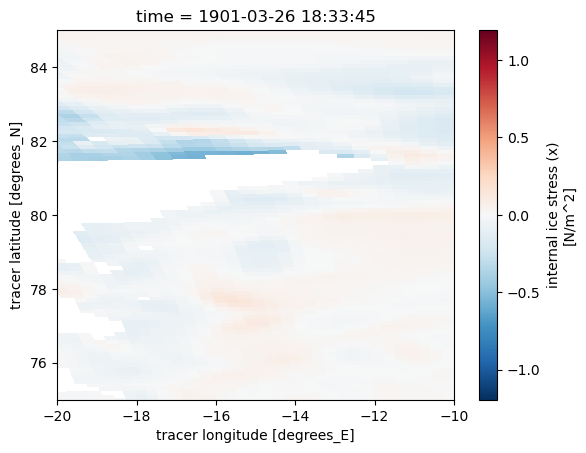

In [33]:
plt.figure()
ax = plt.subplot()

inst_ds.strintx_1.isel(time=49).plot(ax=ax, x = 'geolon_t' , y = 'geolat_t')
plt.ylim([75,85])
plt.xlim([-20,-10])

# ax.add_patch(plt.Rectangle((-16,80.125),width=3, height=3, color='black', fill=None))
# ax.add_patch(plt.Rectangle((-14.8643879243489,81.6865092532964),width=0.1, height=0.1, color='black', fill=None))


In [34]:
crash_point = inst_ds.isel(ni=1068,nj=1001)

In [35]:
crash_point

<xarray.Dataset> Size: 161kB
Dimensions:      (time: 320, nbnd: 2, nkice: 4, nksnow: 1, nkbio: 3, nkaer: 5,
                  nc: 5)
Coordinates:
  * time         (time) object 3kB 1901-03-26 00:11:15 ... 1901-03-30 23:48:45
    NCAT         (nc) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    ni           float64 8B -12.88
    nj           float64 8B 81.71
    geolon_t     float32 4B ...
    geolat_t     float32 4B ...
Dimensions without coordinates: nbnd, nkice, nksnow, nkbio, nkaer, nc
Data variables: (12/50)
    time_bounds  (time, nbnd) object 5kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    VGRDi        (time, nkice) float64 10kB dask.array<chunksize=(1, 4), meta=np.ndarray>
    VGRDs        (time, nksnow) float64 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    VGRDb        (time, nkbio) float64 8kB dask.array<chunksize=(1, 3), meta=np.ndarray>
    VGRDa        (time, nkaer) float64 13kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    blkmask      (time) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    ...           ...
    dvidtt_1     (time) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    dvidtd_1     (time) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    dvirdgdt_1   (time) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    aicen_1      (time, nc) float64 13kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    TLON         float32 4B ...
    TLAT         float32 4B ...
Attributes:
    title:               access-om3
    contents:            Diagnostic and Prognostic Variables
    source:              CICE Sea Ice Model, unknown_version_name
    comment:             All years have exactly 365 days
    comment2:            File written on model date 19010326
    comment3:            seconds elapsed into model date:   1350
    time_period_freq:    step_1
    time_axis_position:  middle
    conventions:         CF-1.0
    history:             This dataset was created on 2024-12-03 at 16:41
    io_flavor:           io_pio2 hdf5

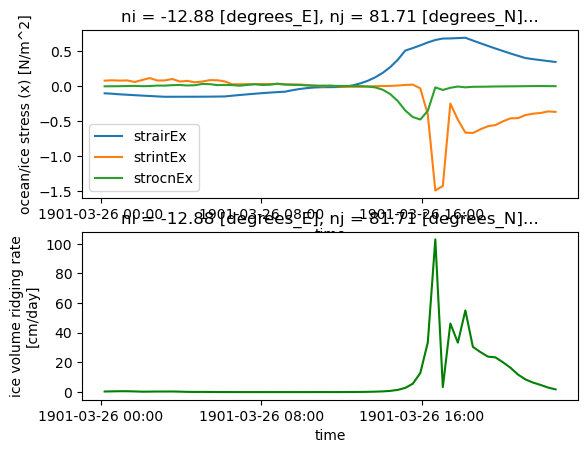

In [37]:
plt.subplot(2,1,1)
crash_point.strairxE_1.isel(time=range(0,61)).plot(label='strairxE')
crash_point.strintxE_1.isel(time=range(0,61)).plot(label='strintxE')
crash_point.strocnxE_1.isel(time=range(0,61)).plot(label='strocnxE')

plt.legend()

plt.subplot(2,1,2)
crash_point.dvirdgdt_1.isel(time=range(0,61)).plot(c='g')

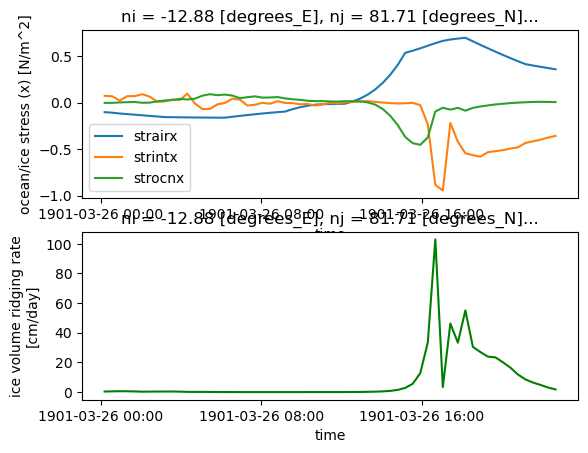

In [51]:
plt.subplot(2,1,1)
crash_point.strairx_1.isel(time=range(0,61)).plot(label='strairx')
crash_point.strintx_1.isel(time=range(0,61)).plot(label='strintx')
crash_point.strocnx_1.isel(time=range(0,61)).plot(label='strocnx')

plt.legend()

plt.subplot(2,1,2)
crash_point.dvirdgdt_1.isel(time=range(0,61)).plot(c='g')

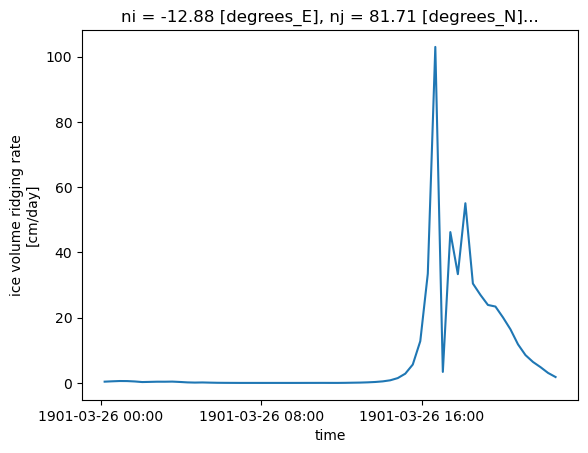

In [39]:
crash_point.dvirdgdt_1.isel(time=range(0,61)).plot()

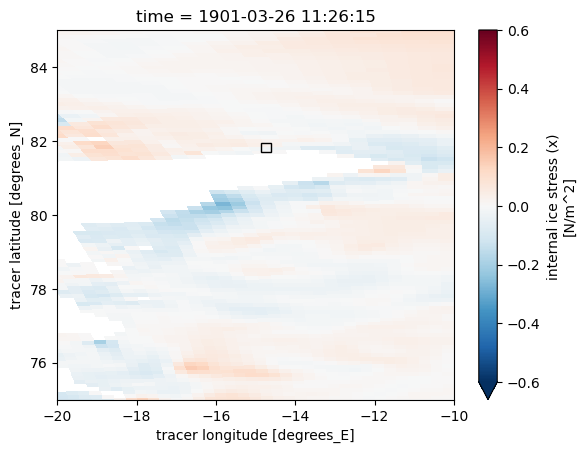

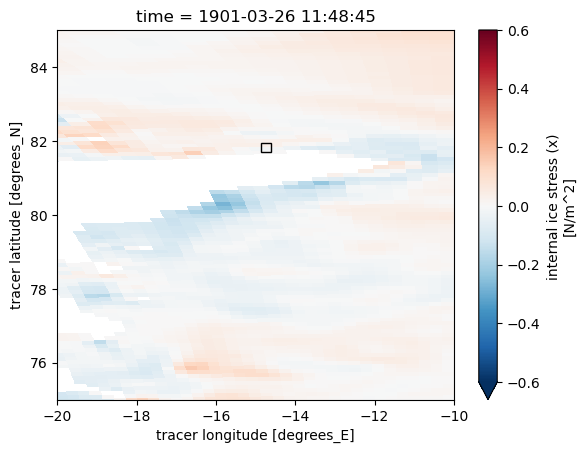

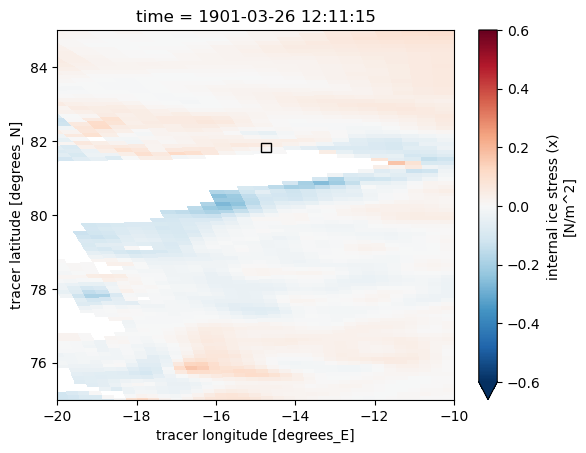

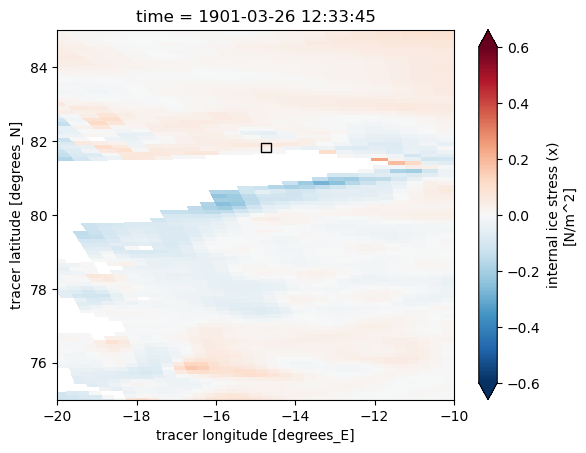

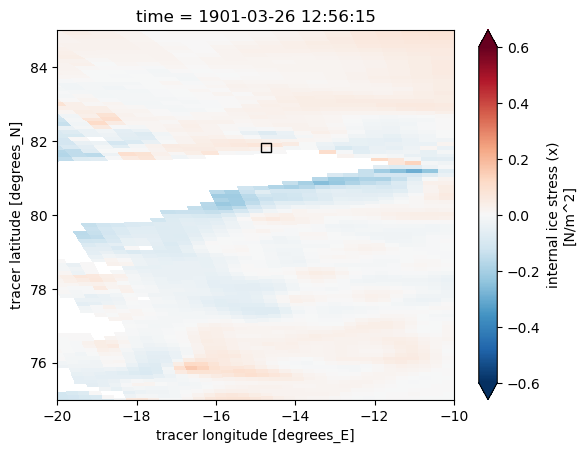

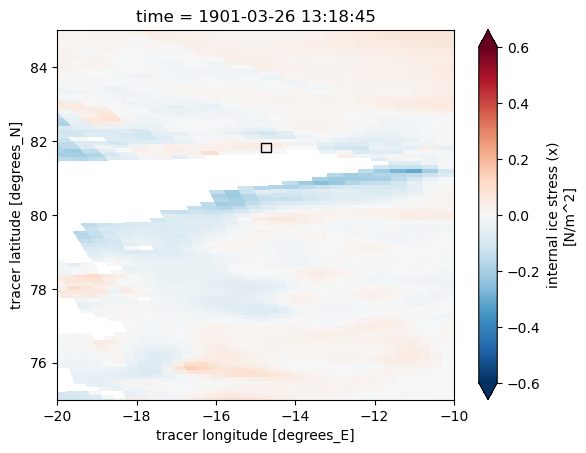

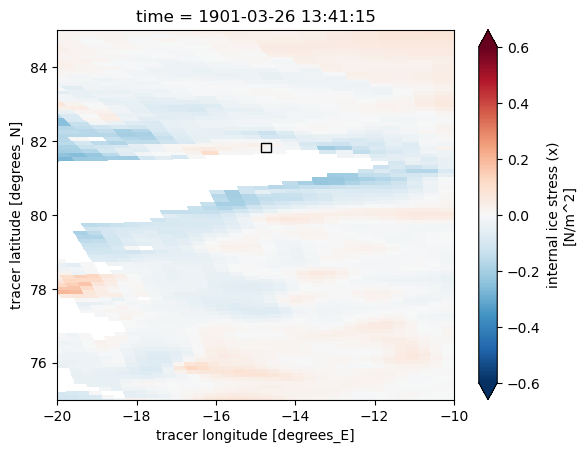

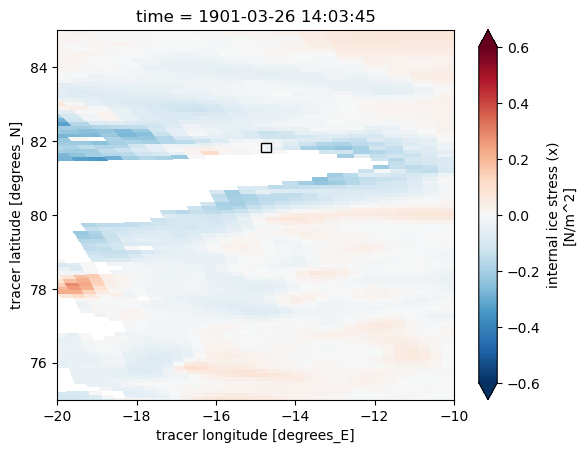

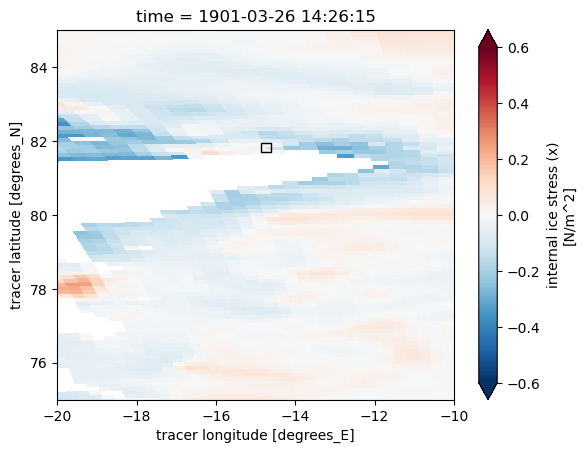

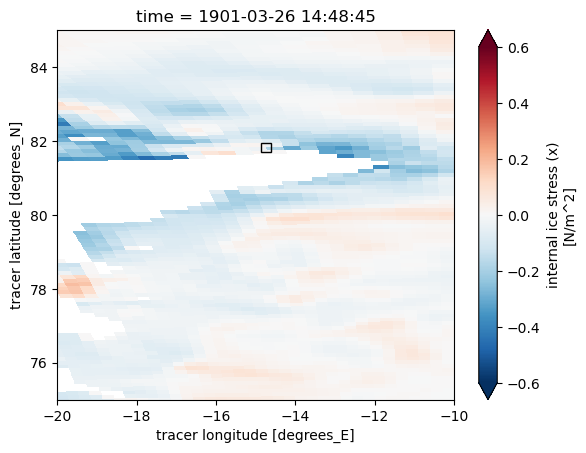

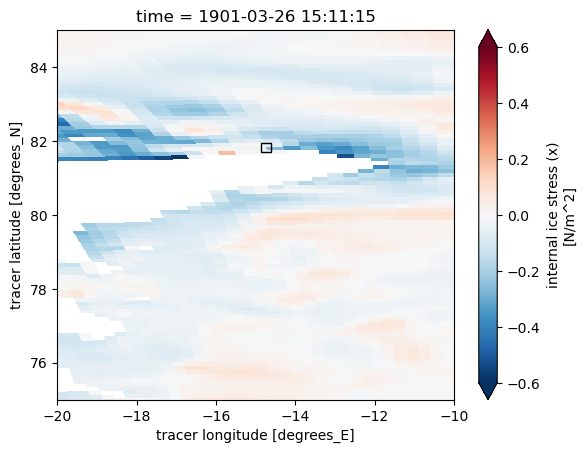

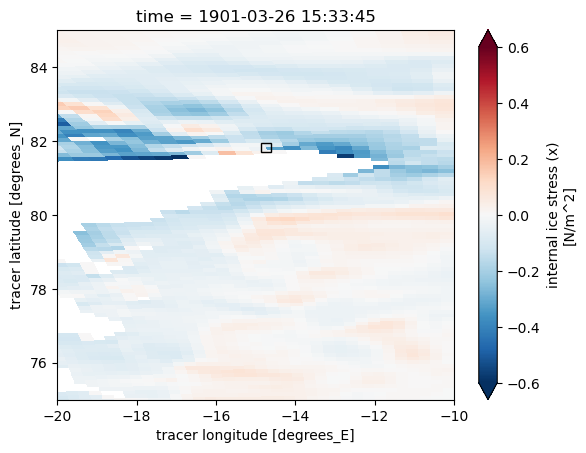

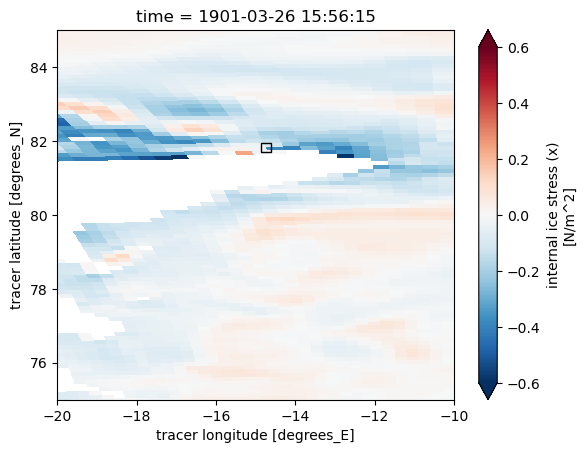

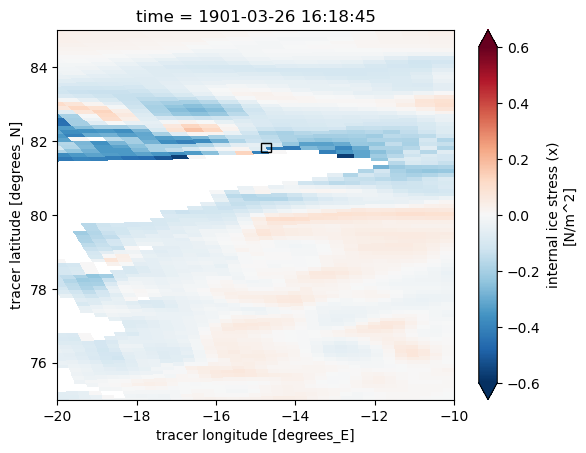

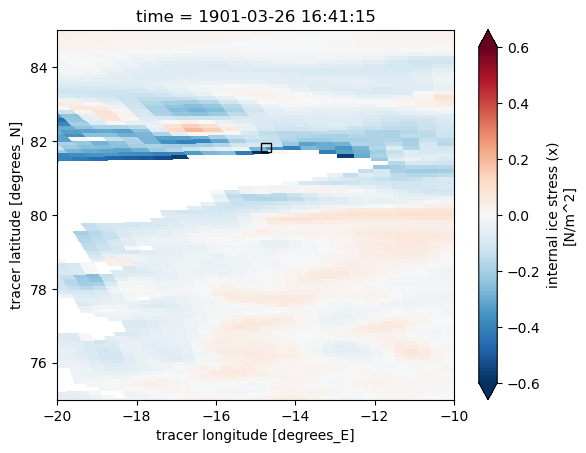

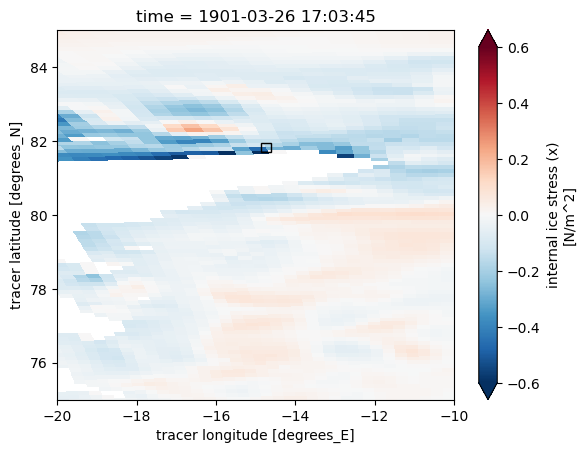

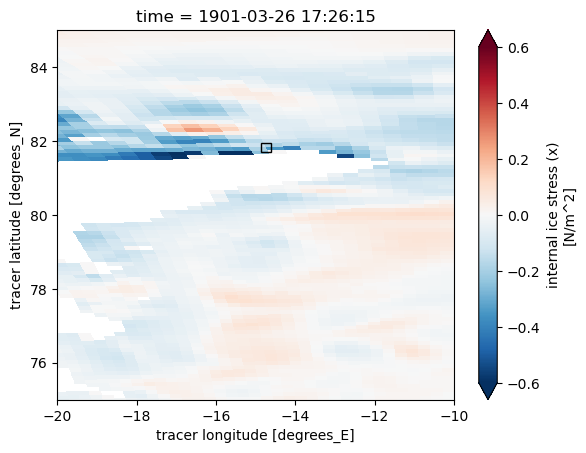

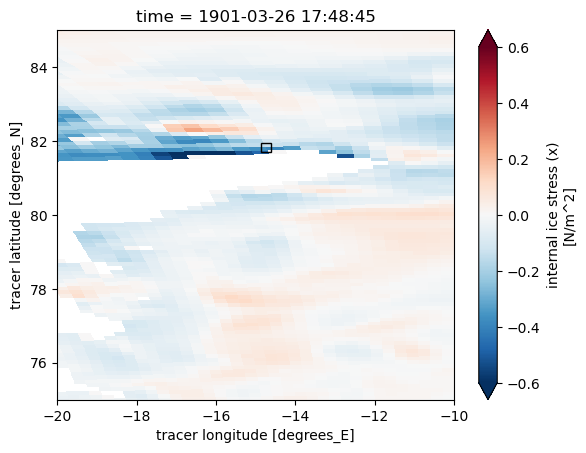

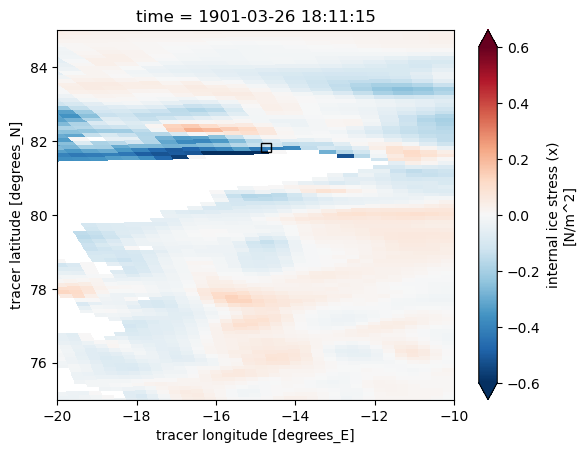

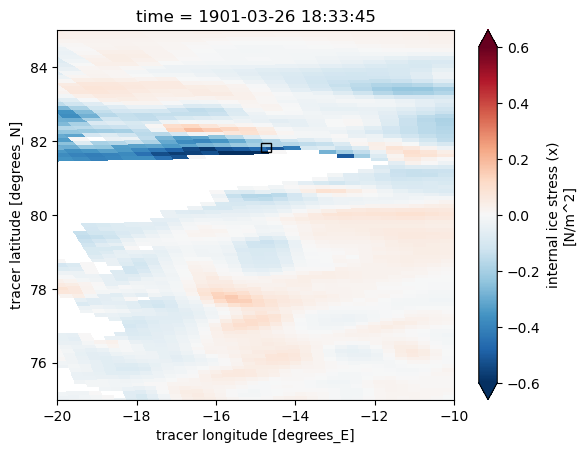

In [49]:
for t in range(30,50):
    plt.figure()
    ax = plt.subplot()
    
    inst_ds.strintxE_1.isel(time=t).plot(ax=ax, x='geolon_t' , y='geolat_t', vmin=-0.6, vmax=0.6, cmap='RdBu_r')
    plt.ylim([75,85])
    plt.xlim([-20,-10])
    
    # ax.add_patch(plt.Rectangle((-16,80.125),width=3, height=3, color='black', fill=None))
    ax.add_patch(plt.Rectangle((-14.8643879243489,81.6865092532964),width=0.25, height=0.25, color='black', fill=None))

    plt.show()


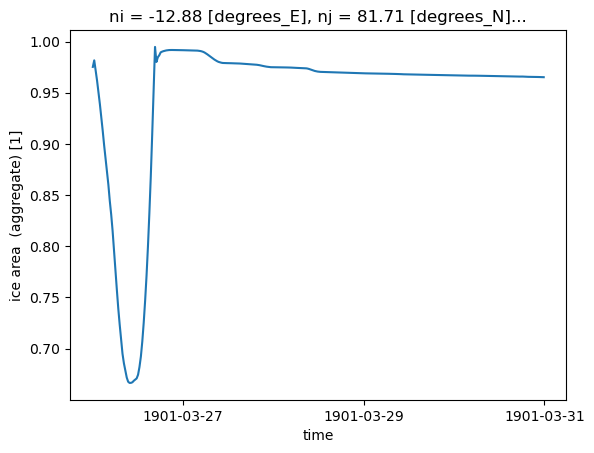

In [39]:
crash_point.aice_1.plot()

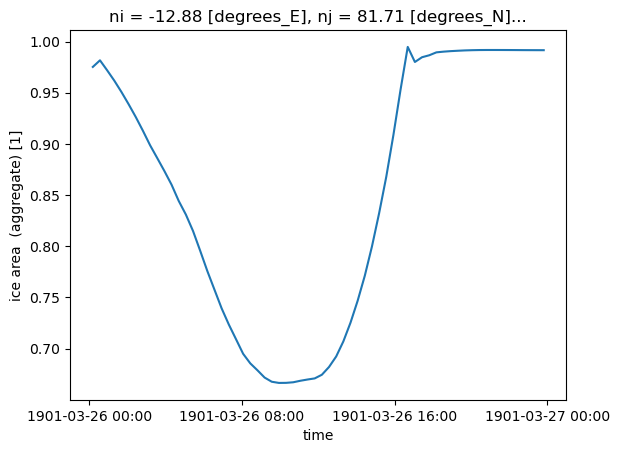

In [40]:
crash_point.sel(time=slice('1901-03-25','1901-03-26')).aice_1.plot()

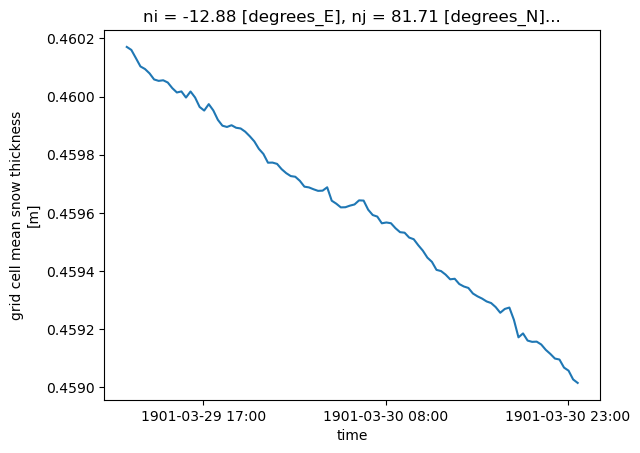

In [41]:
crash_point.isel(time=slice(-100,None)).hs_1.plot()

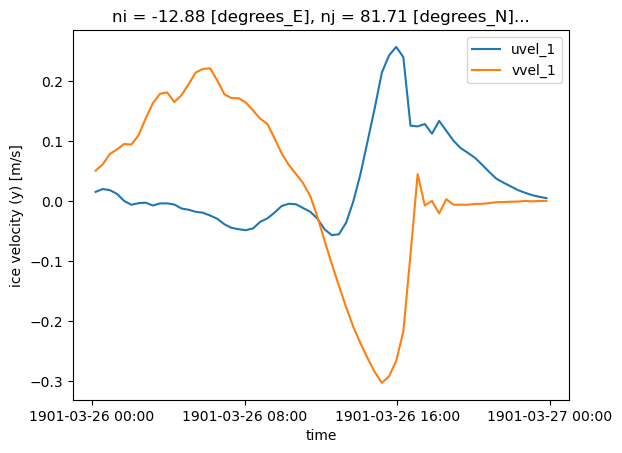

In [42]:
for v in ['uvel_1','vvel_1', 
          # 'uvelE_1', #'vvelE_1', 
          # 'uvelN_1', #'vvelN_1'
         ]:
    crash_point[v].sel(time=slice('1901-03-25','1901-03-26')).plot(label=v)

plt.legend()

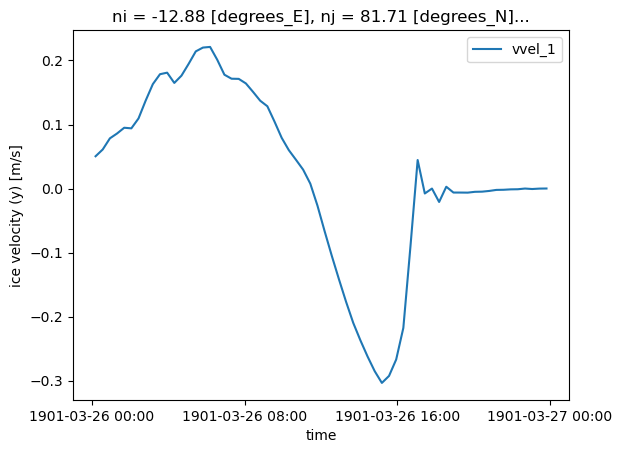

In [43]:
for v in ['vvel_1', 
          # 'vvelE_1', 
          # 'vvelN_1'
         ]:
    crash_point[v].sel(time=slice('1901-03-25','1901-03-26')).plot(label=v)

plt.legend()

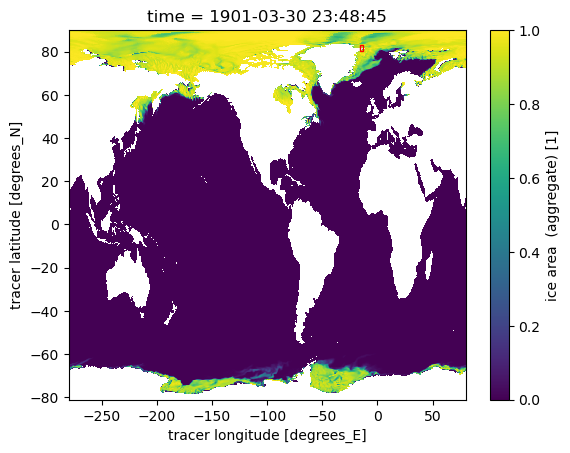

In [44]:
plt.figure()
ax = plt.subplot()

inst_ds.aice_1.isel(time=-1).plot(ax=ax, x = 'geolon_t' , y = 'geolat_t')
# plt.ylim([75,85])
# plt.xlim([-20,-10])

ax.add_patch(plt.Rectangle((-16,80.125),width=3, height=3, color='red', fill=None))
ax.add_patch(plt.Rectangle((-14.8643879243489,81.6865092532964),width=0.1, height=0.1, color='black', fill=None))

plt.show()

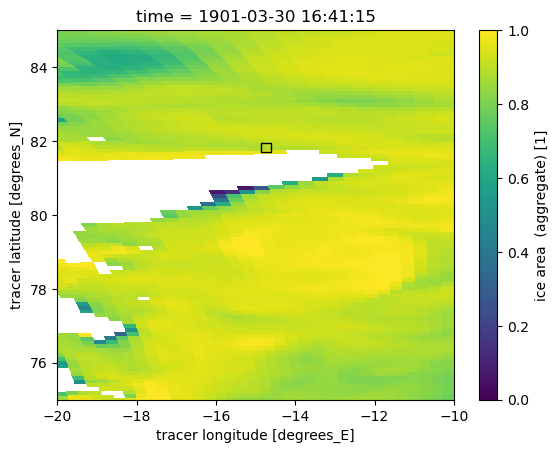

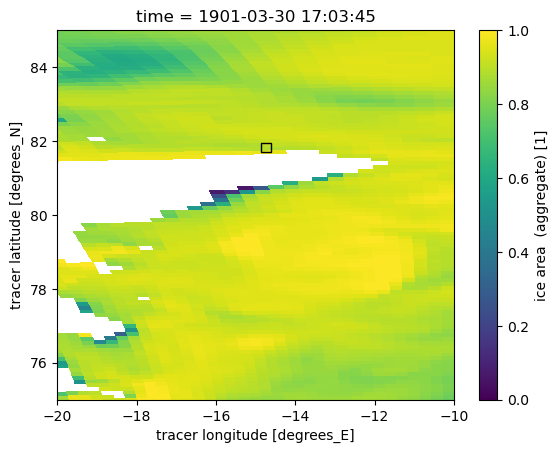

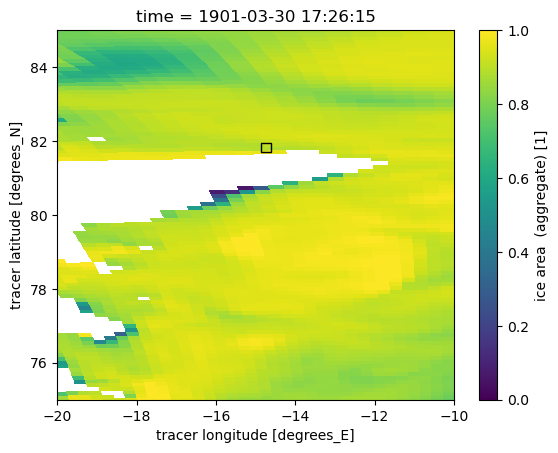

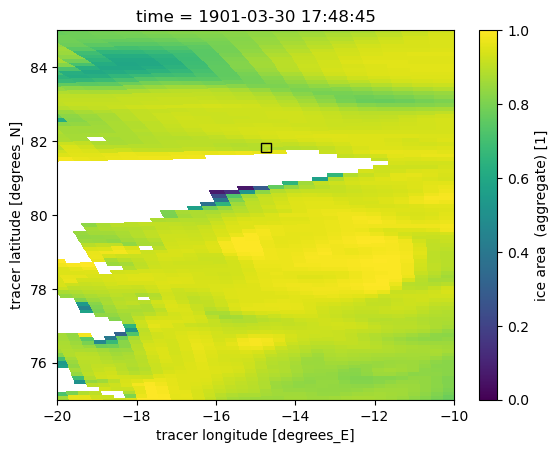

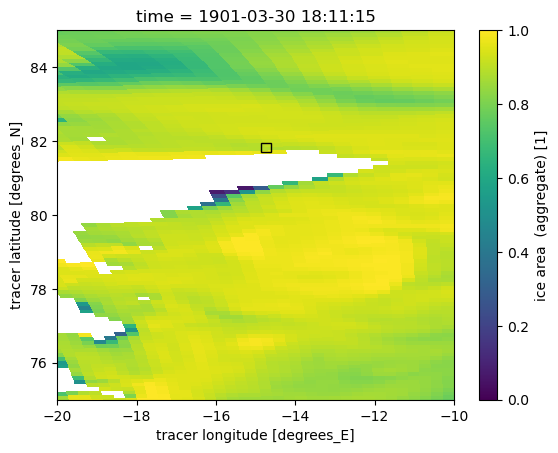

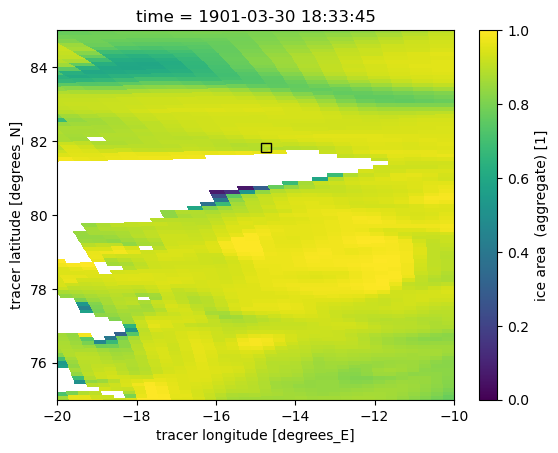

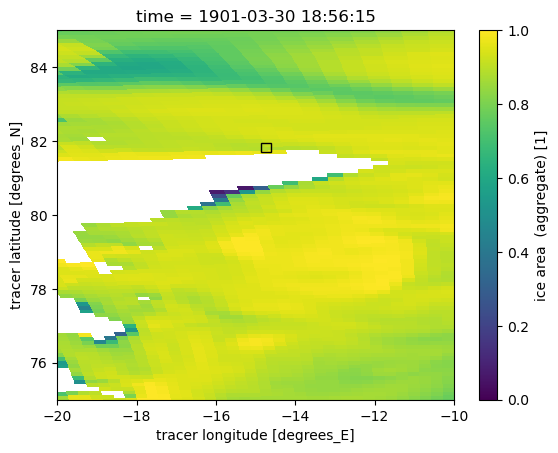

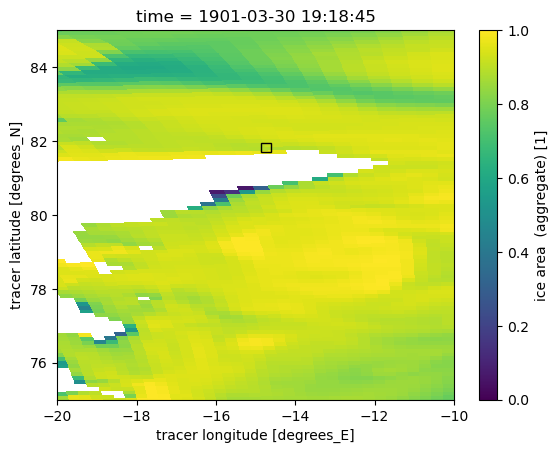

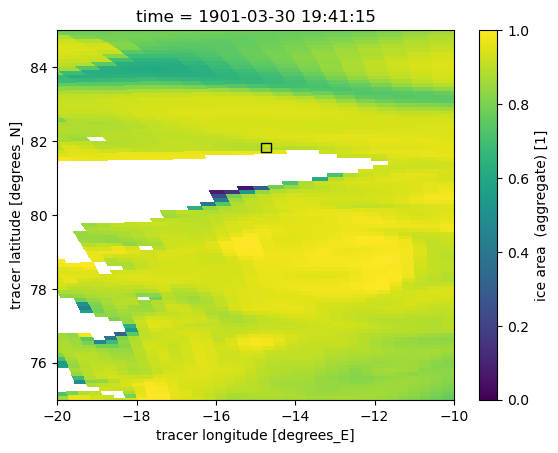

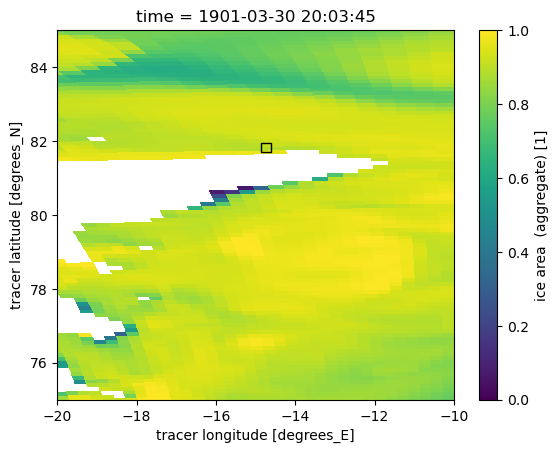

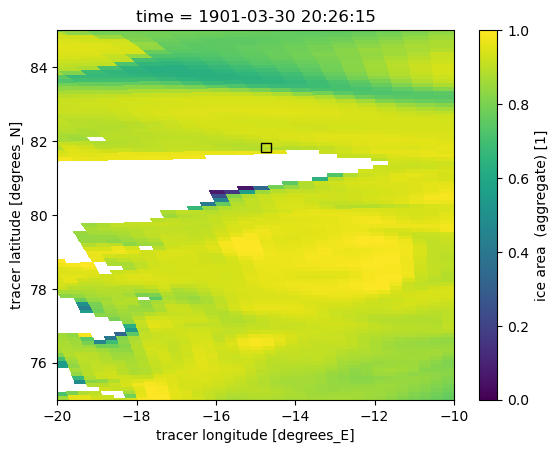

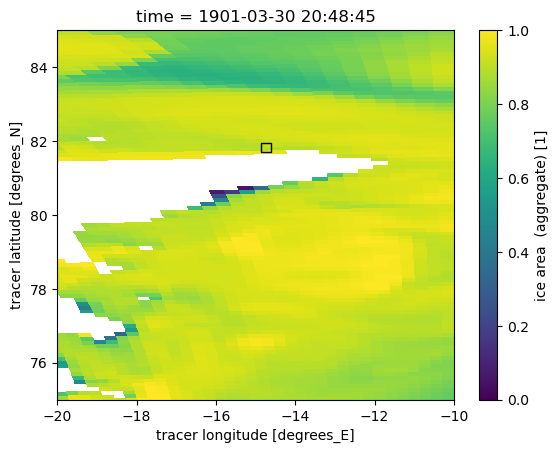

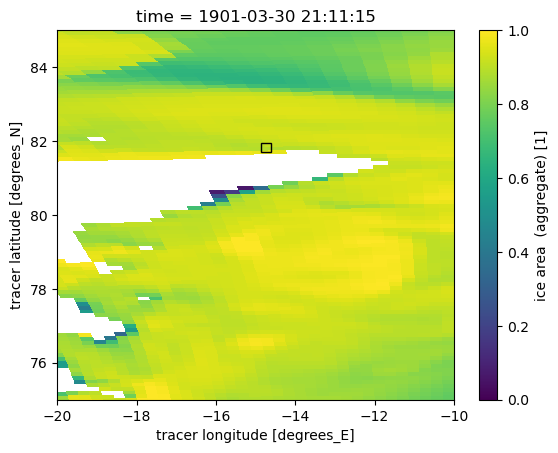

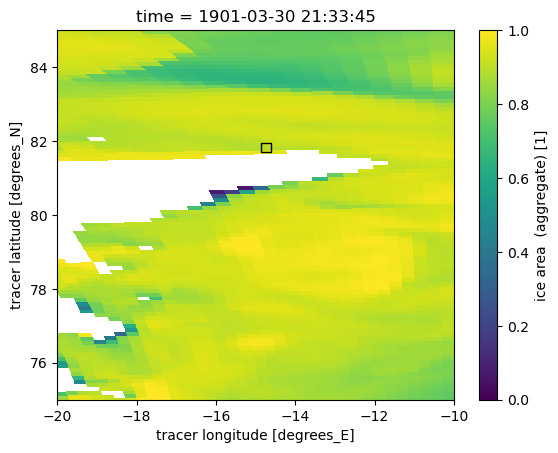

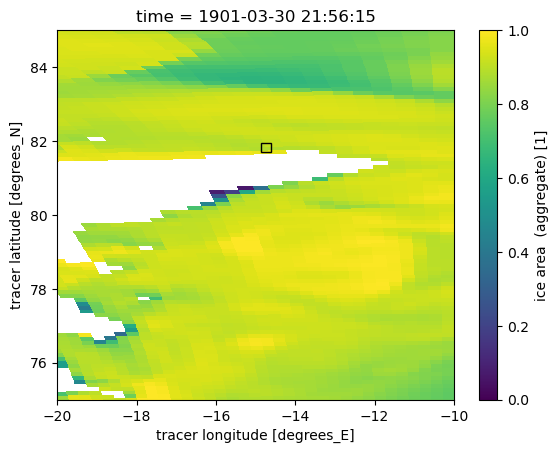

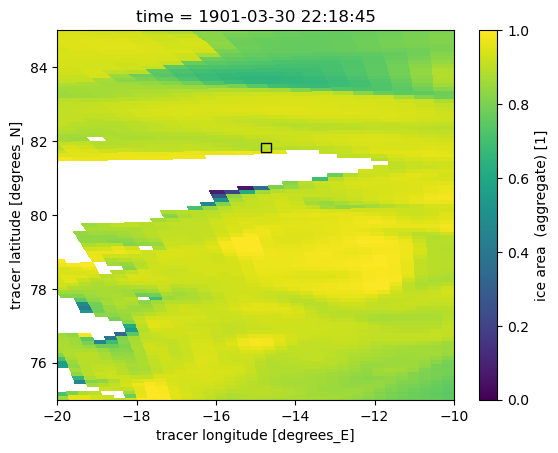

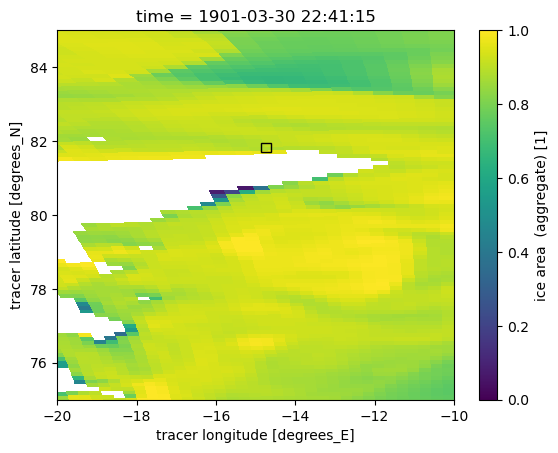

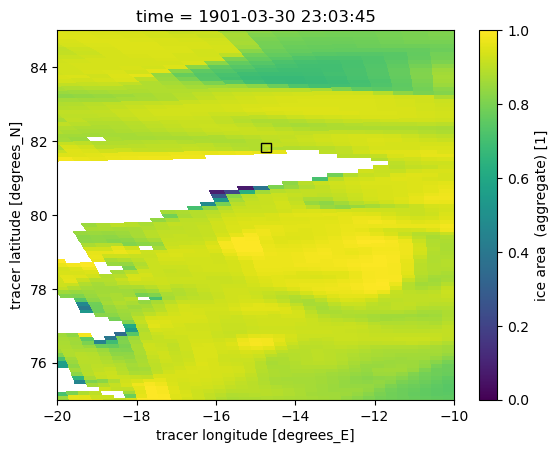

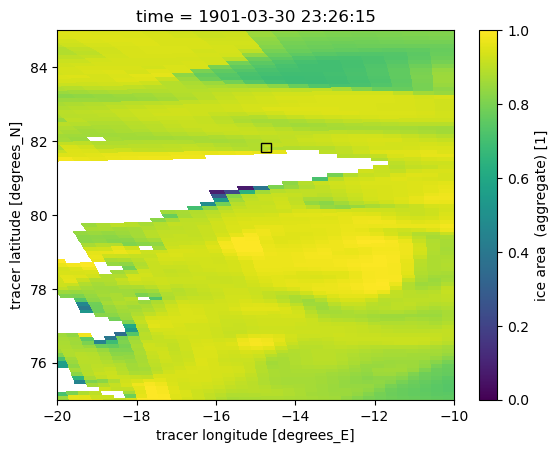

In [45]:
for t in range(-20,-1):
    plt.figure()
    ax = plt.subplot()
    
    inst_ds.aice_1.isel(time=t).plot(ax=ax, x='geolon_t' , y='geolat_t')
    plt.ylim([75,85])
    plt.xlim([-20,-10])
    
    # ax.add_patch(plt.Rectangle((-16,80.125),width=3, height=3, color='black', fill=None))
    ax.add_patch(plt.Rectangle((-14.8643879243489,81.6865092532964),width=0.25, height=0.25, color='black', fill=None))

    plt.show()


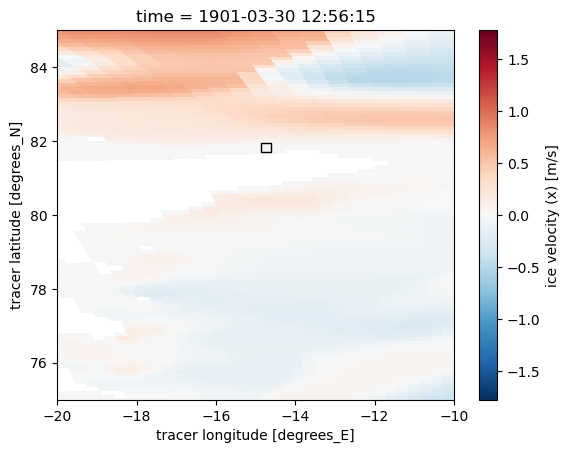

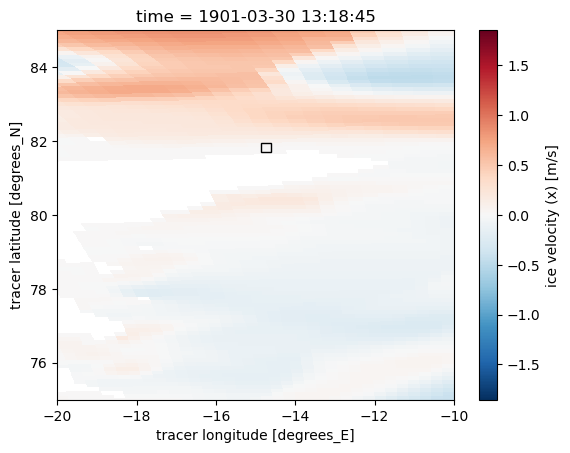

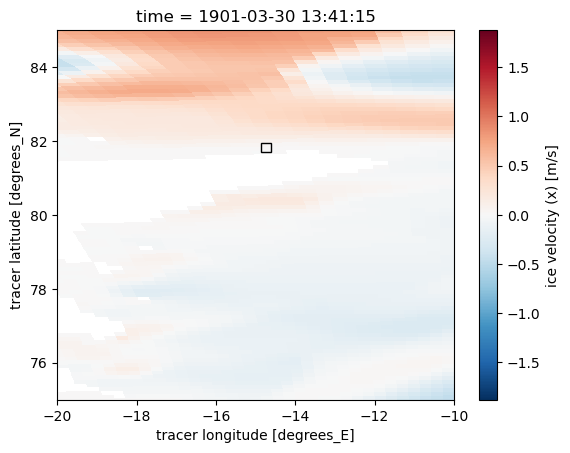

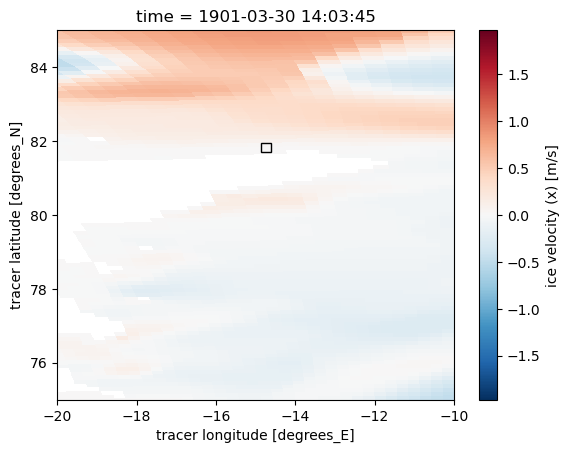

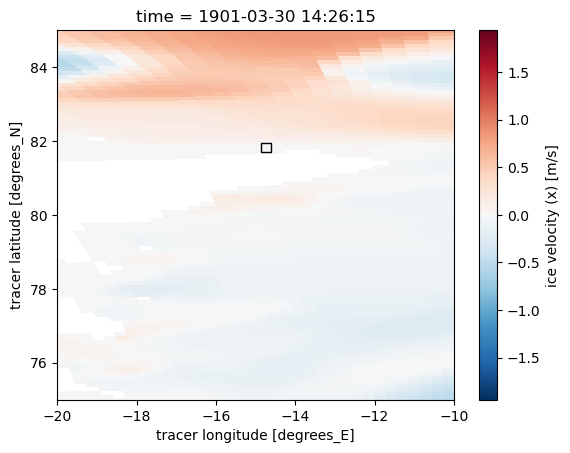

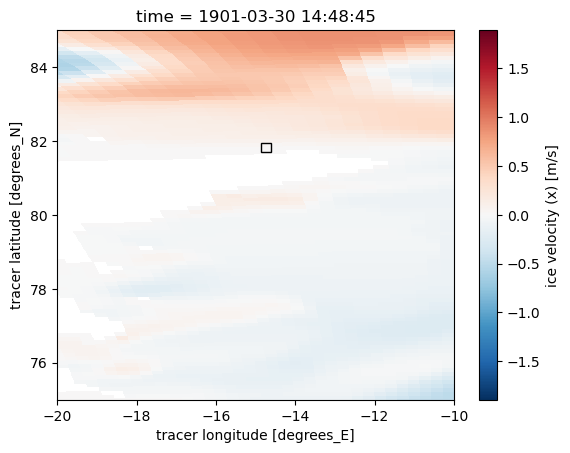

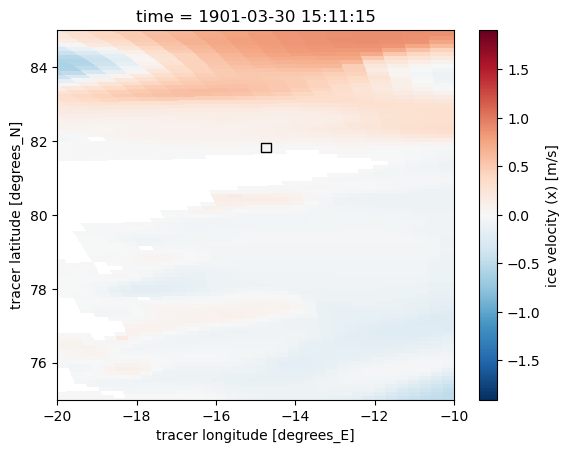

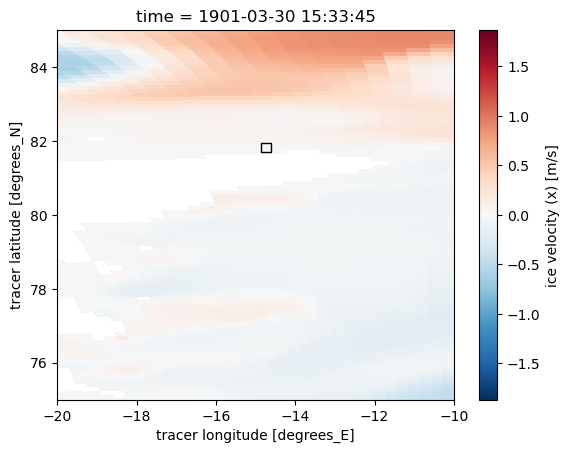

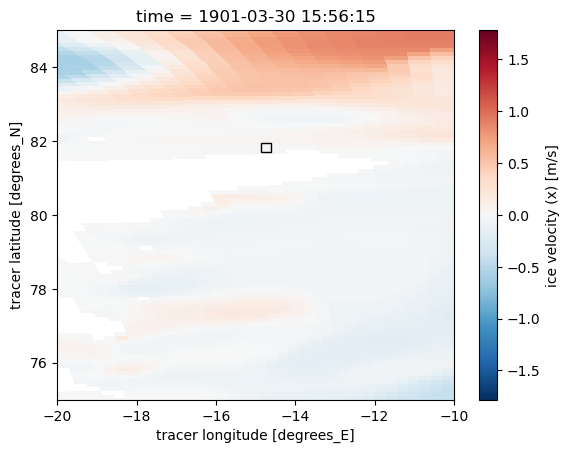

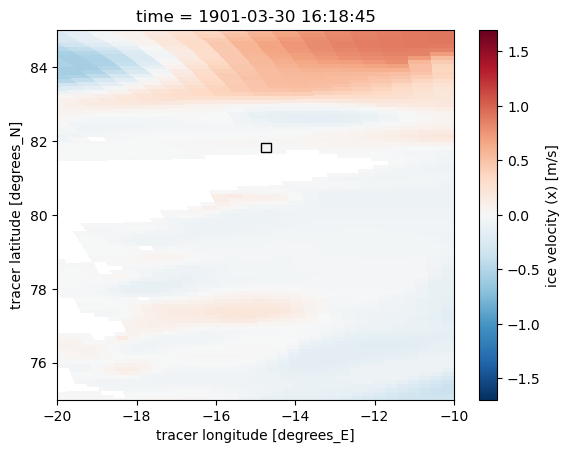

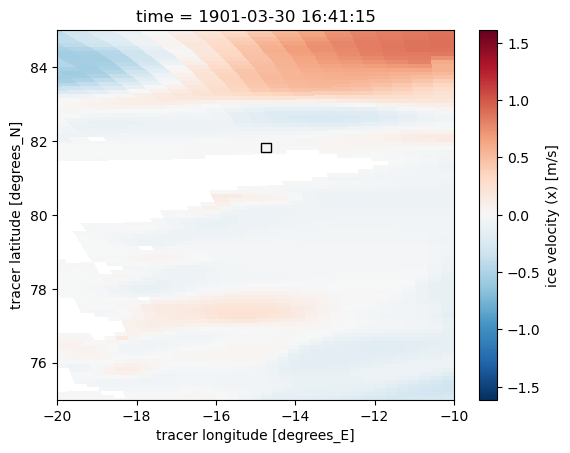

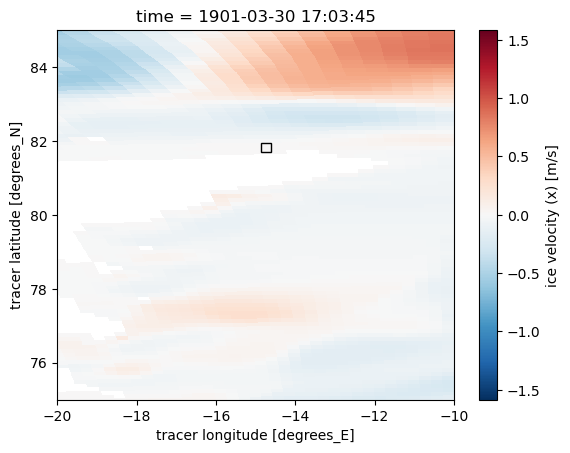

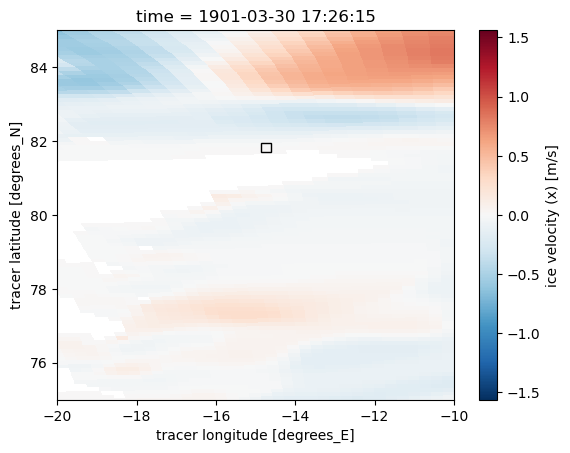

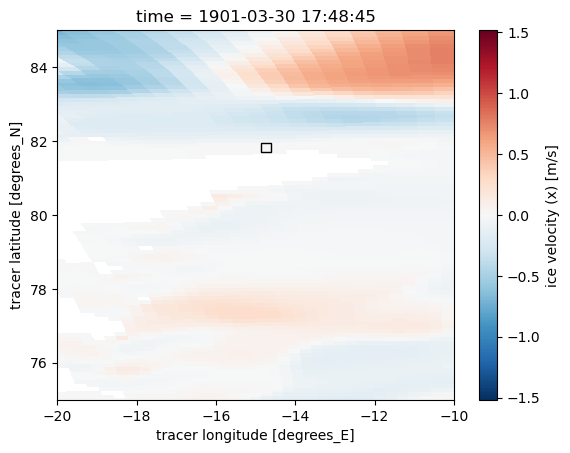

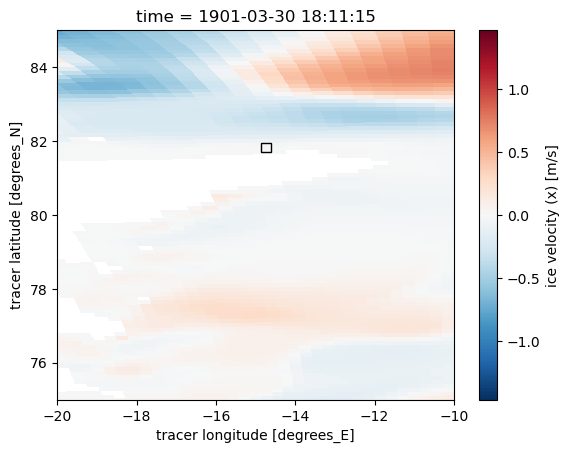

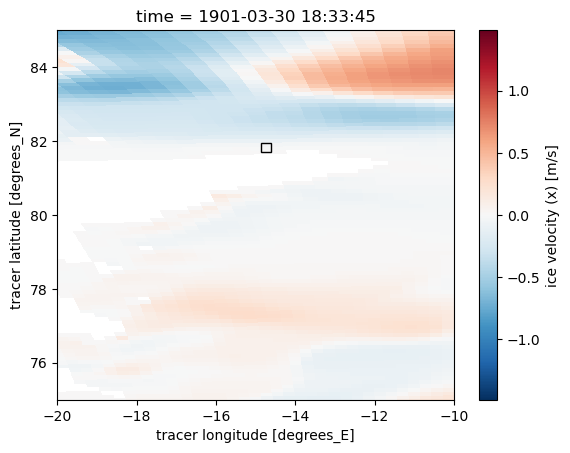

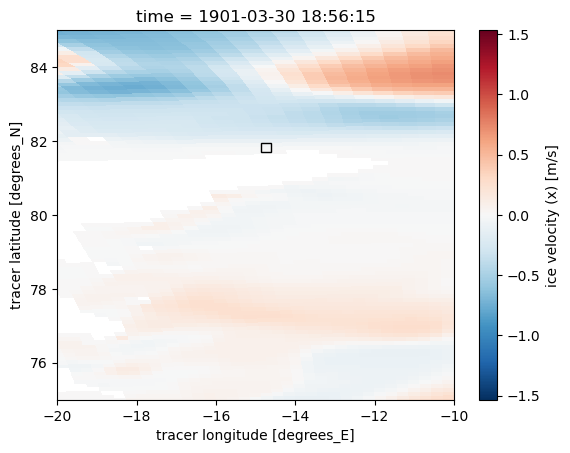

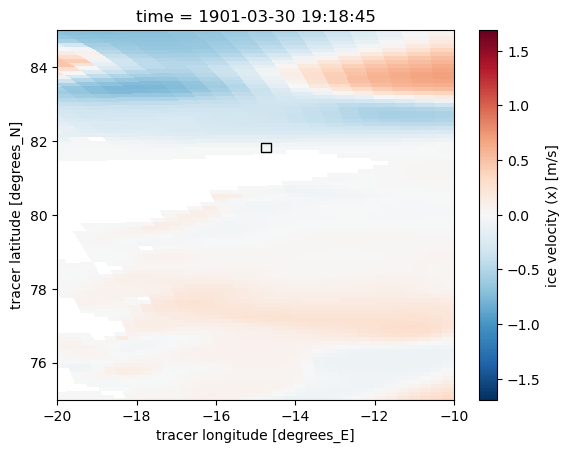

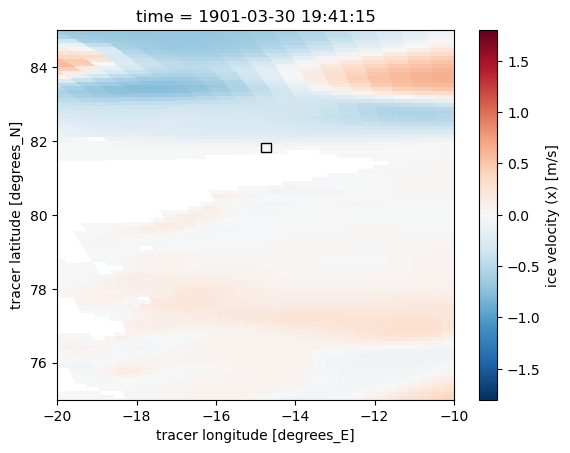

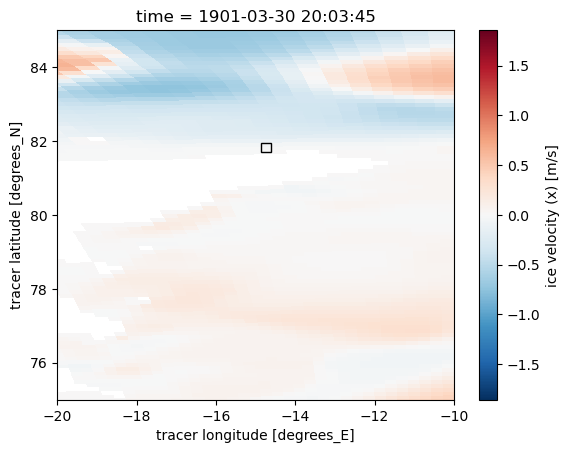

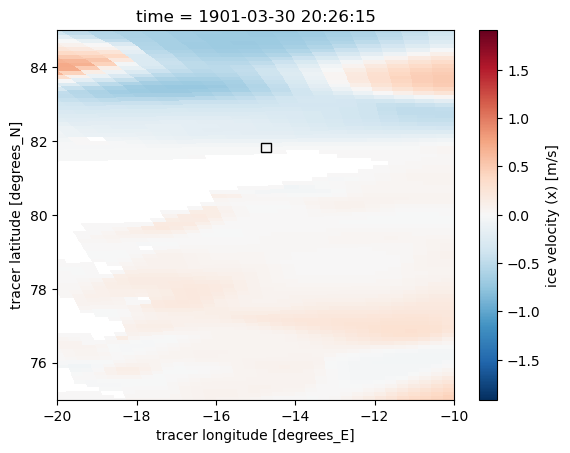

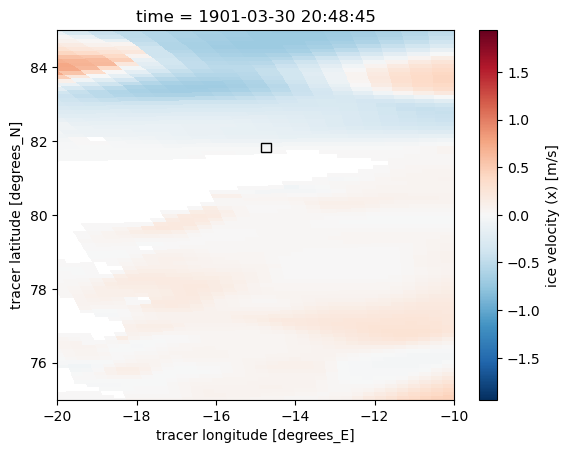

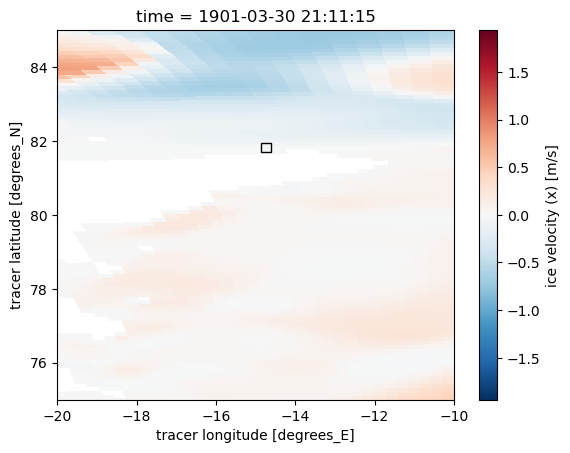

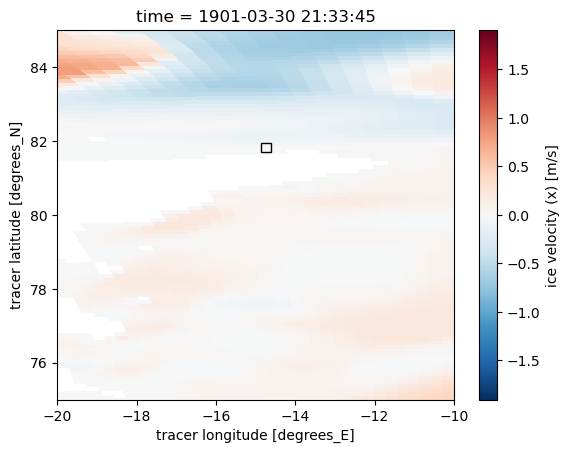

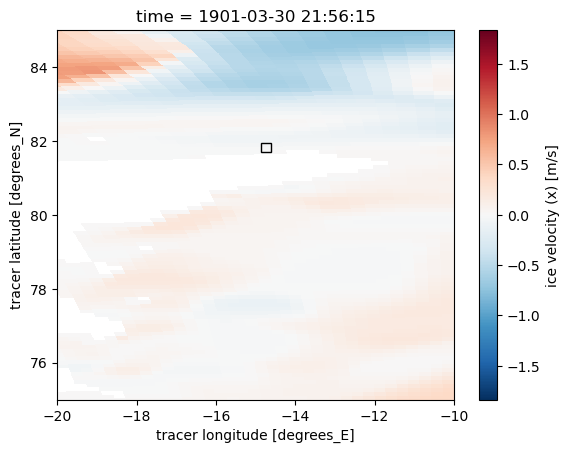

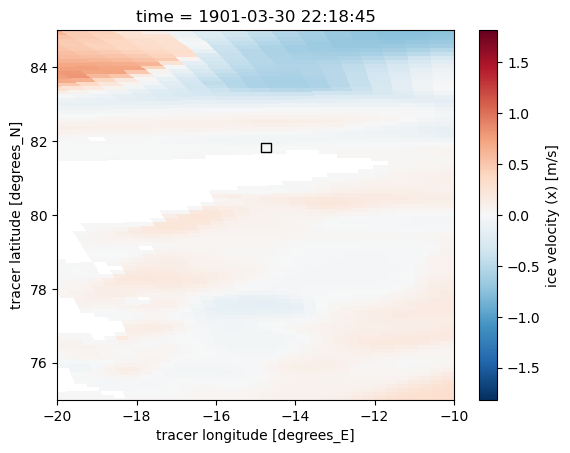

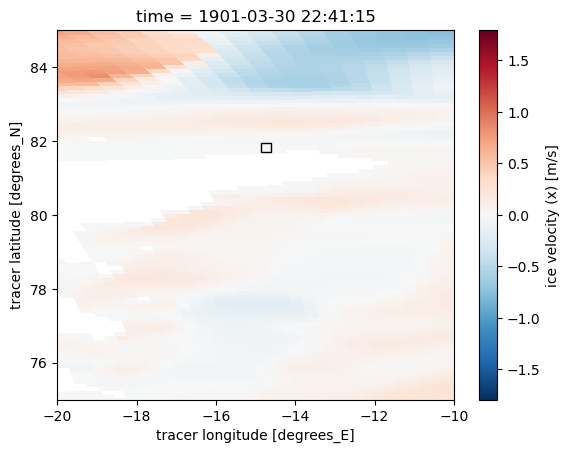

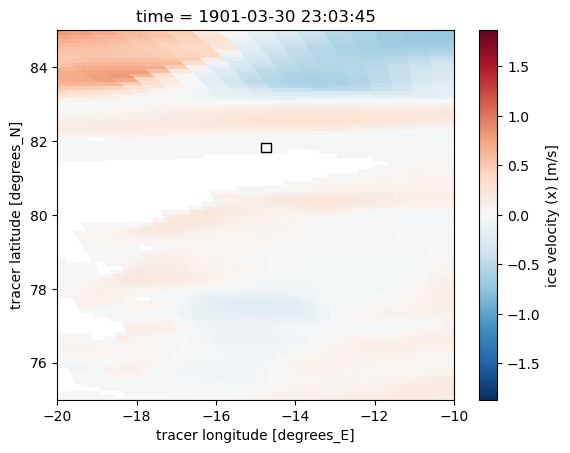

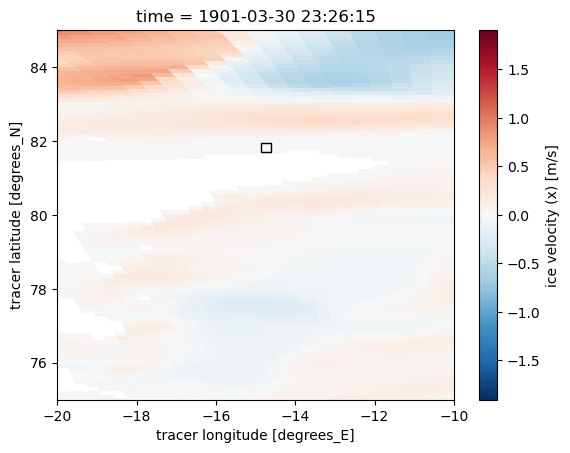

In [46]:
for t in range(-30,-1):
    plt.figure()
    ax = plt.subplot()
    
    inst_ds.uvel_1.isel(time=t).plot(ax=ax, x = 'geolon_t' , y = 'geolat_t')
    plt.ylim([75,85])
    plt.xlim([-20,-10])
    
    # ax.add_patch(plt.Rectangle((-16,80.125),width=3, height=3, color='black', fill=None))
    ax.add_patch(plt.Rectangle((-14.8643879243489,81.6865092532964),width=0.25, height=0.25, color='black', fill=None))

    plt.show()


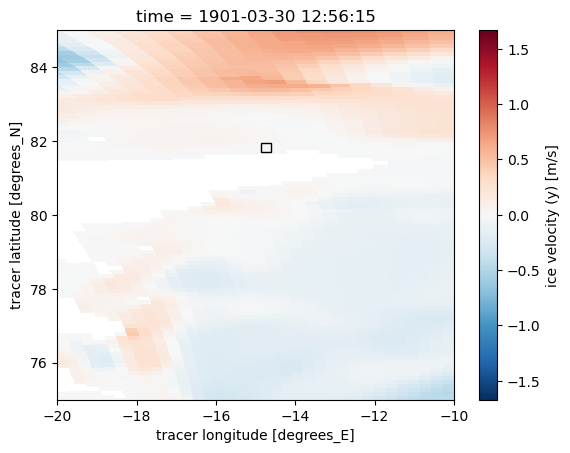

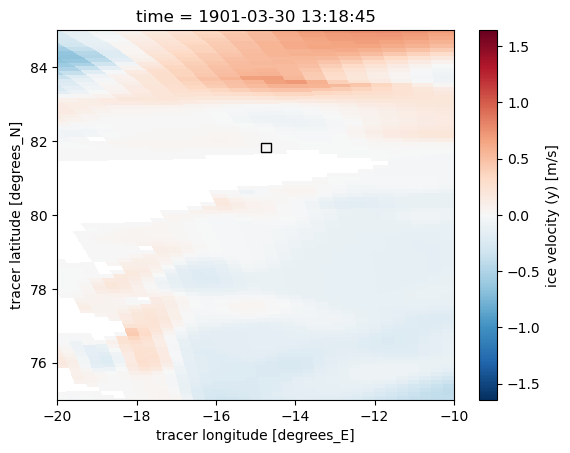

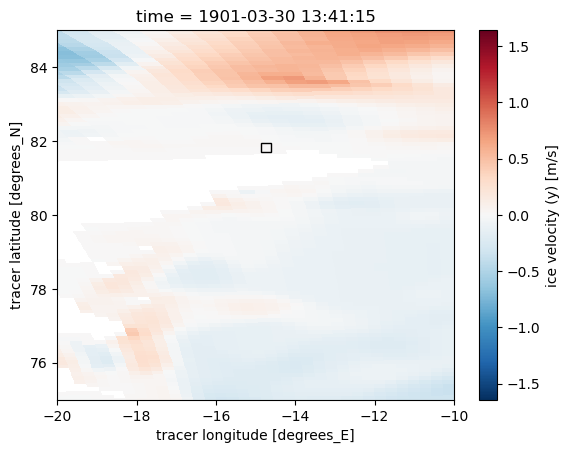

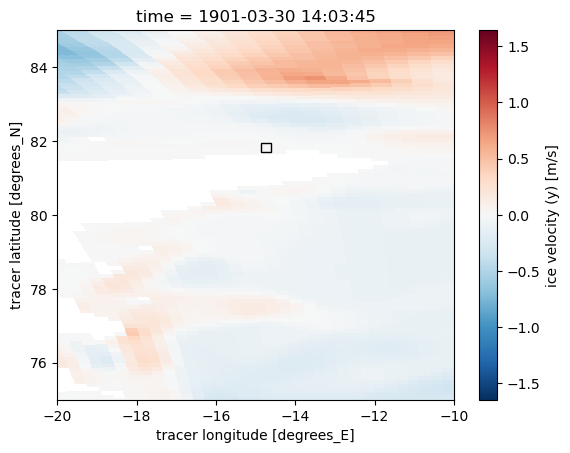

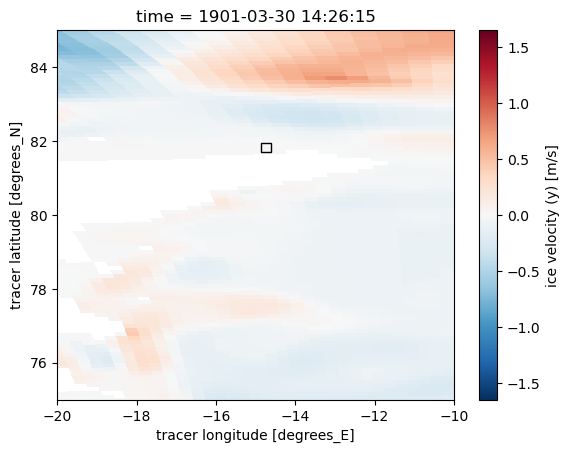

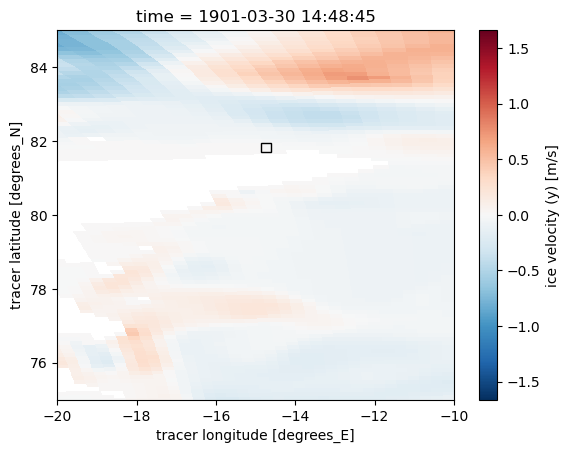

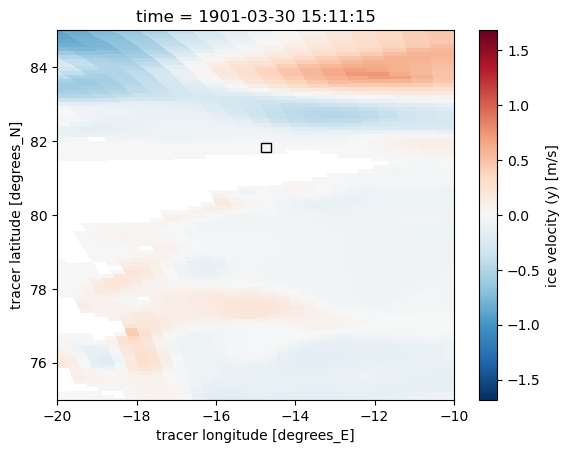

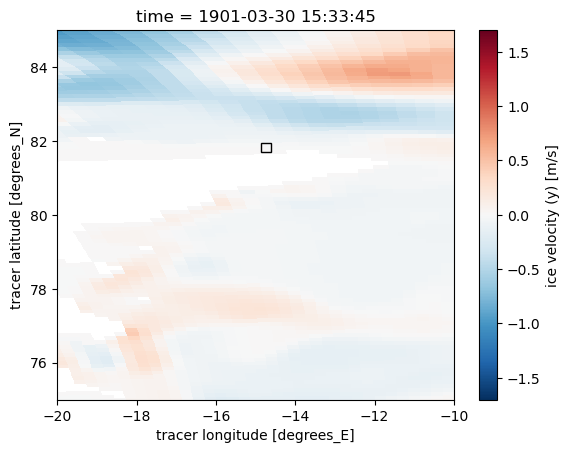

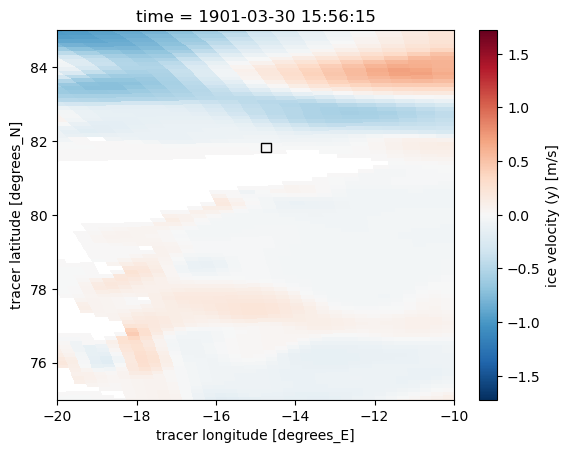

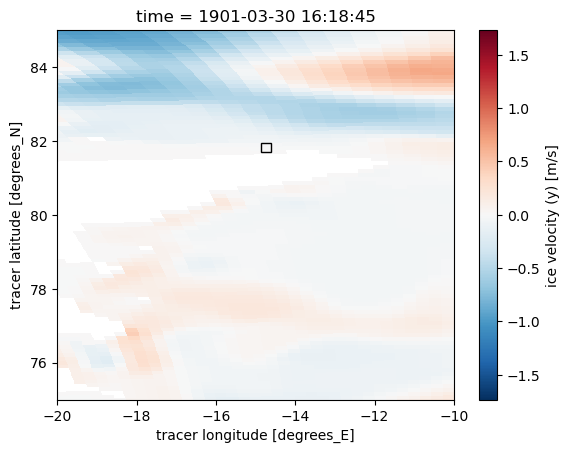

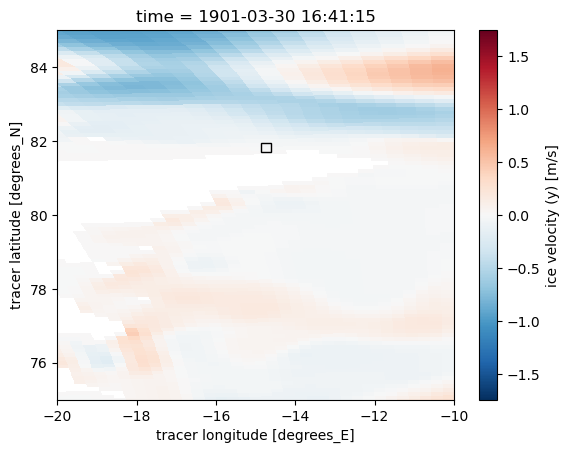

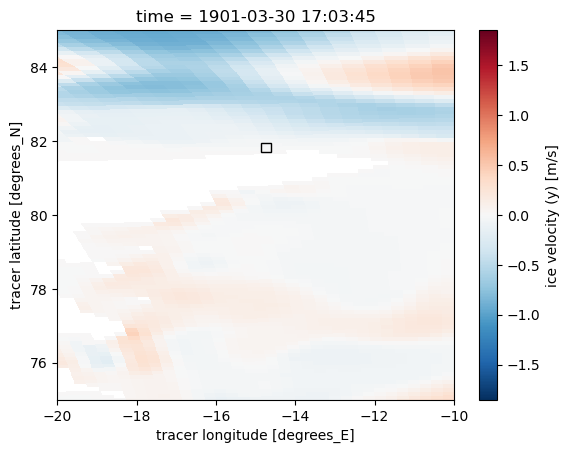

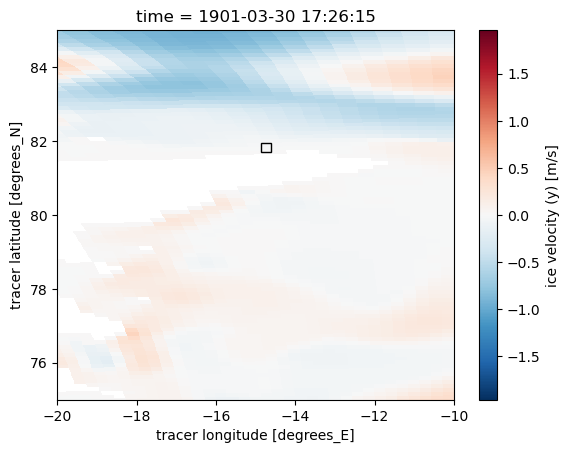

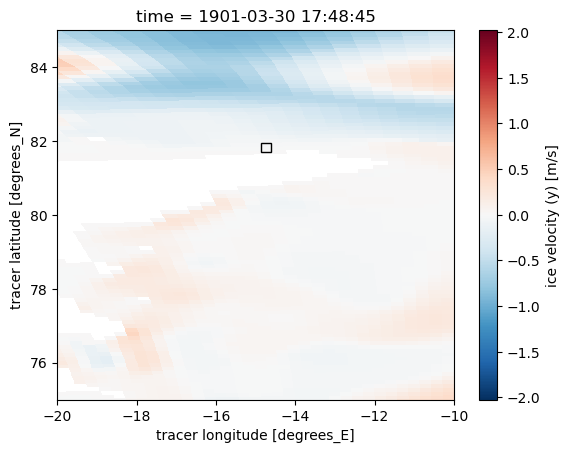

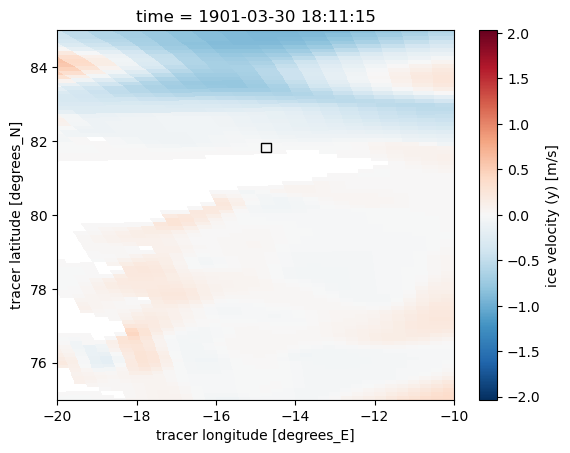

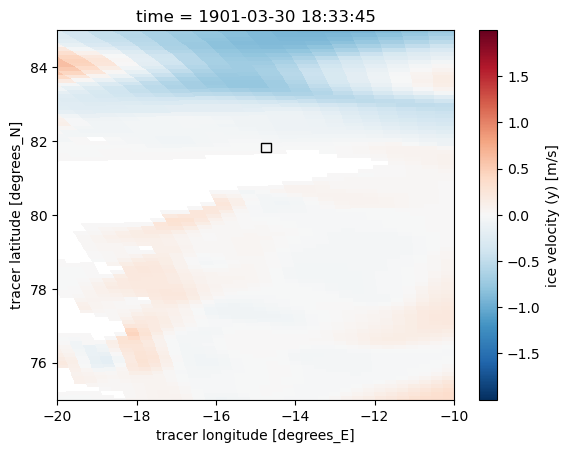

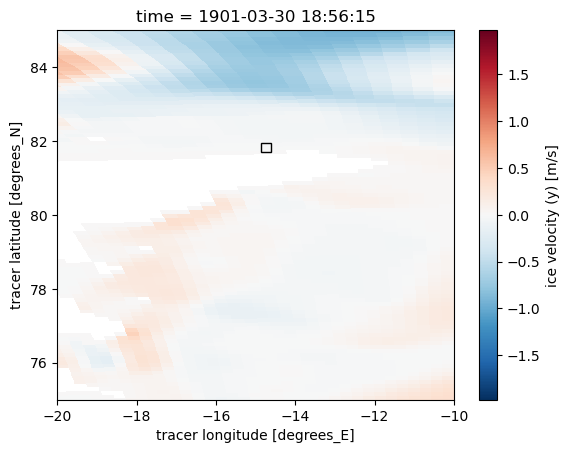

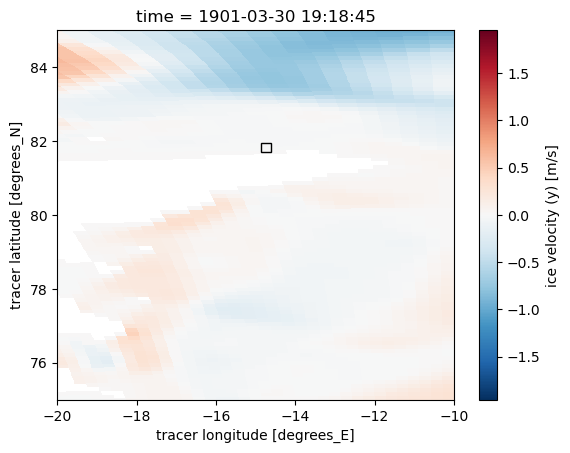

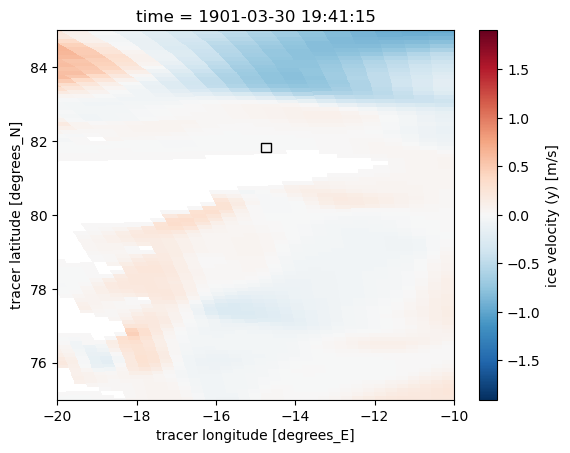

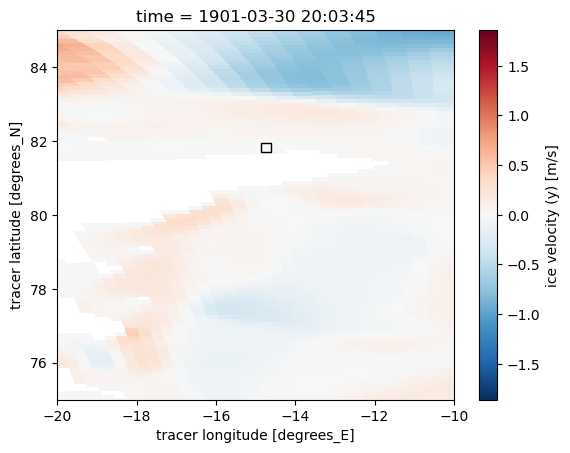

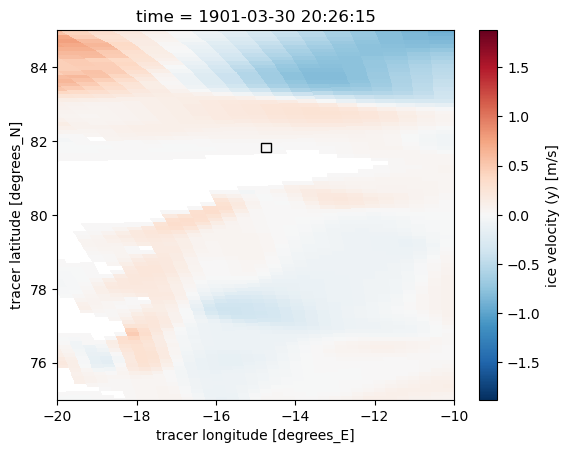

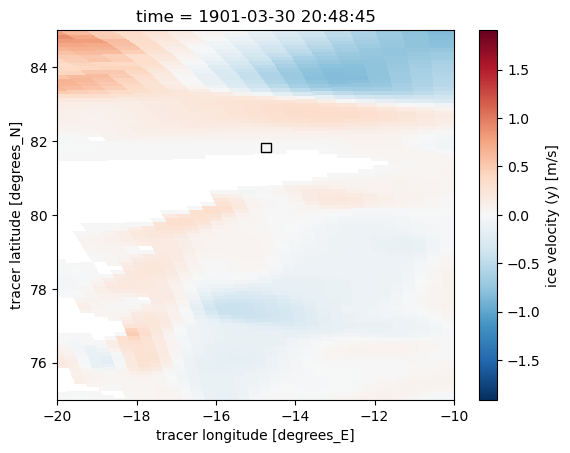

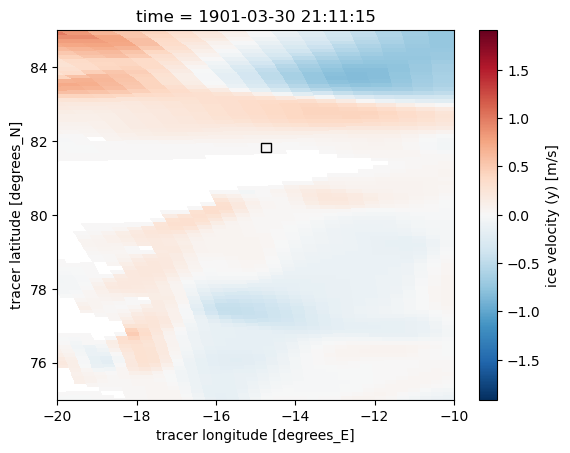

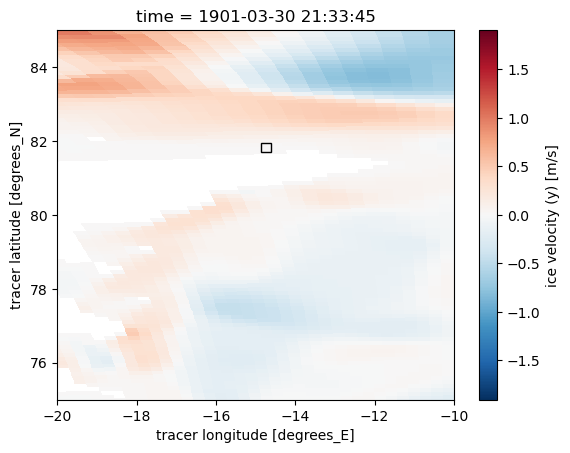

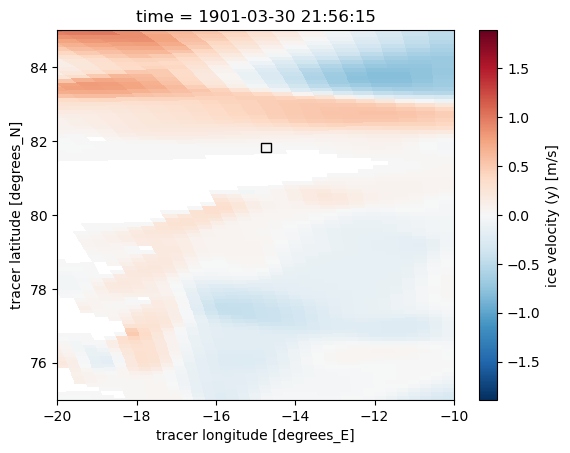

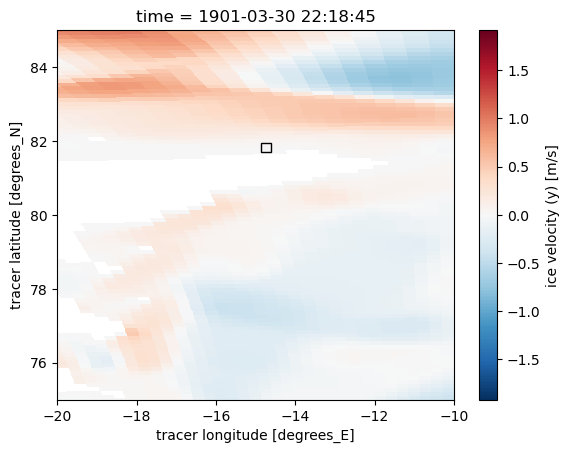

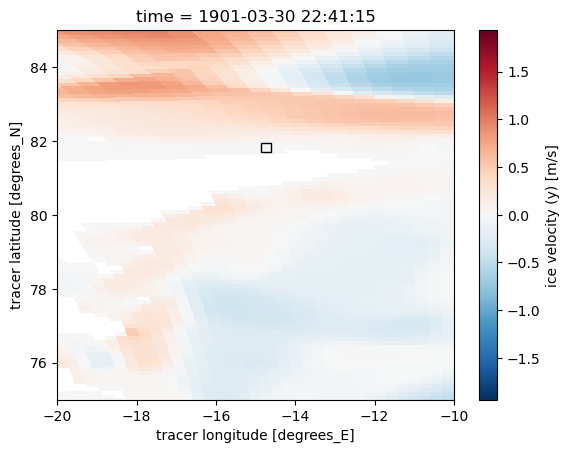

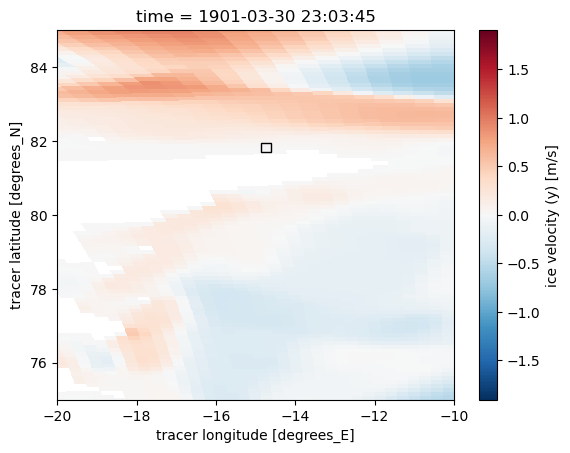

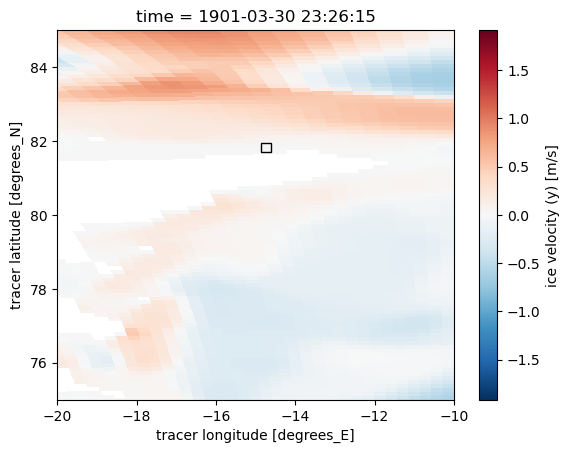

In [47]:
for t in range(-30,-1):
    plt.figure()
    ax = plt.subplot()
    
    inst_ds.vvel_1.isel(time=t).plot(ax=ax, x = 'geolon_t' , y = 'geolat_t')
    plt.ylim([75,85])
    plt.xlim([-20,-10])
    
    # ax.add_patch(plt.Rectangle((-16,80.125),width=3, height=3, color='black', fill=None))
    ax.add_patch(plt.Rectangle((-14.8643879243489,81.6865092532964),width=0.25, height=0.25, color='black', fill=None))

    plt.show()


In [48]:
client.close()